# Оптимизация маркетинговых затрат в Яндекс.Афише

### Содержание


- [**Шаг 1. Общая информация о данных**](#part_1)
    - [1.1. Введение в проект](#101)
    - [1.2. Описание данных](#102)
    - [1.3. Выводы из общей информации о данных](#103)


- [**Шаг 2. Подсчет метрик**](#part_2)
    - [**2.1. Продуктовые метрики**](#201)
        - [2.1.1. Сколько людей пользуются в день, неделю, месяц?](#2011)
        - [2.1.2. Сколько сессий в день?](#2012)
        - [2.1.3. Сколько длится одна сессия?](#2013)
        - [2.1.4. Как часто люди возвращаются?](#2014)
        - [2.1.5. Выводы из анализа продуктовых метрик](#2015)
    - [**2.2. Метрики продаж**](#202)
        - [2.2.1. Сколько времени проходит до первой покупки?](#2021)
        - [2.2.2. Сколько раз покупают за период?](#2022)
        - [2.2.3. Какой средний чек?](#2023)
        - [2.2.4. Сколько денег приносят?](#2024)
        - [2.2.5. Выводы из анализа метрик продаж](#2025)
    - [**2.3. Маркетинговые метрики**](#203)
        - [2.3.1. Сколько всего денег потратили?](#2031)
        - [2.3.2. Сколько стоило привлечение одного пользователя?](#2032)
        - [2.3.3. Насколько окупились расходы?](#2033)
        - [2.3.4. Выводы из анализа маркетинговых метрик](#2034)


- [**Шаг 3. Общий вывод**](#part_3)

<a id='part_1'></a>
## Шаг 1. Общая информация о данных

<a id='101'></a>
### Введение в проект

Доступны данные сервиса Яндекс.Афиша с июня 2017 до конца мая 2018 года. Они включают:
- лог с сервера о посещениях сайта за год, 
- выгрузка всех заказов за этот период, 
- ежедневная статистика рекламных расходов.

Нужно предложить оптимизацию маркетинговых затрат, изучив метрики на основе имеющихся данных. Для этого рассмотрим, как люди пользуются продуктом, когда начинают покупать, сколько прибыли получаем с одного покупателя и сколько стоит его привлечение, а также как окупаются маркетинговые инвестиции.

<a id='102'></a>
### Описание данных

Таблица `visits` (лог сервера с информацией о посещениях сайта):
- `Uid` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Start Ts` — дата и время начала сессии
- `End Ts` — дата и время окончания сессии
- `Source Id` — идентификатор рекламного источника, из которого пришел пользователь


Таблица `orders` (информация о заказах):
- `Uid` — уникальный id пользователя, который сделал заказ
- `Buy Ts` — дата и время заказа
- `Revenue` — выручка Яндекс.Афиши с этого заказа


Таблица `costs` (информация о затратах на маркетинг):
- `source_id` — идентификатор рекламного источника
- `dt` — дата
- `costs` — затраты на этот рекламный источник в этот день

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# глобальные настройки отображения графиков
sns.mpl.rc('figure', figsize=(15, 9)) # размер графиков
sns.mpl.rc('axes', grid=False) # отключение фоновой сетки
sns.set_style('ticks', {'xtick.major.size': 8, 'ytick.major.size': 8}) # отображение отметок на осях
sns.set_palette('coolwarm') # установка цветовой схемы
sns.mpl.rc('axes.spines', top=False, right=False) # скрытие рамки вокруг диаграмм

contrast_color = '#909090'
plt.rcParams.update({
    'figure.facecolor':  (1.0, 0.0, 0.0, 0), 
    'axes.facecolor':    (0.0, 1.0, 0.0, 0), 
    'savefig.facecolor': (0.0, 0.0, 1.0, 0), 
    'legend.framealpha': 0.0, 
    'text.color' : contrast_color,
    'axes.labelcolor' : contrast_color, 
    'xtick.color': contrast_color, 
    'ytick.color': contrast_color, 
    'axes.edgecolor': contrast_color
})

In [3]:
# чтение файлов с данными
original_visits = pd.read_csv('./datasets/visits_log.csv')
original_orders = pd.read_csv('./datasets/orders_log.csv')
original_costs = pd.read_csv('./datasets/costs.csv')

# создание рабочих копий файлов с данными
visits = original_visits.copy()
orders = original_orders.copy()
costs = original_costs.copy()

Сразу переведем с помощью функции названия столбцов в нижний регистр, заменим пробелы на знаки нижнего подчеркивания и приведем столбцы с датами к нужному типу:

In [4]:
def preprocessing(data: 'df'):
    
    '''
    Функция принимает датафрейм, 
    переводит названия столбцов датафрейма в нижний регистр и заменяет пробелы, 
    переводит тип столбцов с полными датами из object в datetime
    '''
    
    # переименование столбцов
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(' ', '_')
    
    # перевод дат в формат datetime
    for column_name in data.columns:
        if 'ts' in column_name:
            data[str(column_name)] = pd.to_datetime(data[str(column_name)], format='%Y-%m-%d %H:%M:%S')

Рассмотрим информацию о таблице с сессиями:

In [5]:
preprocessing(visits) # предобработка датафрейма
visits.info() # вывод общей информации о датафрейме
visits.head(10) # вывод первых 10 строк датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Потенциальние ошибки могут возникнуть в столбцах с датами — дата конца сессии не может быть меньше даты начала для отдельного наблюдения, также они не могут быть равны. Посмотрим, есть ли такие некорректные строки, оценим их процент от общих данных и, если их немного, удалим из таблицы:

In [6]:
print('Процент некорректных данных в visits: {:.2%}'
      .format(visits.query('start_ts == end_ts or end_ts < start_ts').shape[0] / visits.shape[0]))
visits = visits.query('start_ts != end_ts and end_ts > start_ts')

Процент некорректных данных в visits: 9.96%


Некорректных данных менее 10%, их можно не включать в анализ.

Рассмотрим информацию о таблице с заказами:

In [7]:
preprocessing(orders) # предобработка датафрейма
orders.info() # вывод общей информации о датафрейме
orders.head(10) # вывод первых 10 строк датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Здесь у нас есть количественная переменная с выручкой, посмотрим на ее распределение:

In [8]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

У нас есть нулевые значения выручки. Возможно, сами такие значения не являются ошибкой (например, это покупки по промокодам или акциям), но лучше всего их будет исключить — они могут повлиять на расчеты средних значений.

In [9]:
print('Процент заказов с нулевой выручкой в orders: {:.2%}'
      .format(orders.query('revenue == 0').shape[0] / orders.shape[0]))
orders = orders.query('revenue != 0')

Процент заказов с нулевой выручкой в orders: 0.10%


0,1% можно безопасно удалить.

Рассмотрим информацию о таблице с затратами:

In [10]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d') # перевод дат в формат datetime
costs.info() # вывод общей информации о датафрейме
costs.head(10) # вывод первых 10 строк датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Здесь присмотримся к количественной переменной с затратами:

In [11]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Не похоже, что здесь есть какие-то явные аномалии.

Наконец, проверим все таблицы на дубликаты:

In [12]:
print('Полных дубликатов в visits:', visits.duplicated().sum())
print('Полных дубликатов в orders:', orders.duplicated().sum())
print('Полных дубликатов в costs:', costs.duplicated().sum())

Полных дубликатов в visits: 0
Полных дубликатов в orders: 0
Полных дубликатов в costs: 0


<a id='103'></a>
### Выводы из общей информации о данных

1. Данные соответствуют полученному описанию. 
1. В них нет дублированных строк или категорий. 
1. Даты приведены к корректным типам, и теперь все типы данных соответствуют признакам. 
1. В таблицах нет пропусков. 
1. Предположительно некорректные значения встретились в таблице `visits` (дата конца сессии была равна или меньше даты начала) и с `orders` (нулевая выручка), от них мы избавились. Других нелогичных значений не обнаружено.


Важно упомянуть, что нам неизвестны источники, скрытые за `source_id`, поэтому описывать мы их будем только по номерам. Неизвестно также, в чем выражаются денежные значения `revenue` и `costs`, поэтому будем называть их просто «деньгами».

<a id='part_2'></a>
## Шаг 2. Подсчет метрик

Введем несколько функций, которые помогут построить когорты и сделать визуализацию.

In [13]:
def lineplotting(data, values, palette='coolwarm', ax=None, style=None, dashes=False, markers=None, 
                 withhue=False, rawdata=True, percents=False, 
                 xlim=None, ylim=None, xlabel=None, ylabel=None, title=None):
    
    '''
    Функция нужна для отрисовки графиков для сгруппированных данных, 
    с возможностью группировки по дополнительным параметрам и вывода исходной таблицы с данными
    
    Аргументы:
    - data: сгруппированные данные, на основе которых строится график, передается в sns.lineplot(data)
    - values: числовая переменная, которую нужно изобразить на графике, передается на ось Y
    - ax: объект matplotlib.axes для указания, где разместить график, нужен для создания сабплотов
    - withhue: если True, в sns.lineplot(hue) передается второй уровень индекса как группирующая переменная
    - rawdata: указатель, нужно ли выводить данные, на основе которых строится график
    - percents: указатель, нужно ли вывести сырые данные в процентах
    '''
    
    data = pd.DataFrame(data)
    
    
    hue = None
    if withhue == True: # параметр для разделения линий графика по второму уровню мультииндекса
        hue = data.index.get_level_values(1)
        
        
    # построение графика
    lineplot = sns.lineplot(data=data, 
                            y=values, 
                            x=data.index.get_level_values(0), 
                            hue=hue, 
                            palette=palette, 
                            ax=ax, 
                            style=style, 
                            dashes=dashes, 
                            markers=markers, 
                            legend='full')
    
    # заголовок и названия осей графика
    lineplot.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=title) 

    # отключение ненужных осей, если графики не в сабплотах
    if ax == None:
        sns.despine(trim=True, offset=5) 
        
    
    # параметр для вывода исходных данных, по которым строится график
    if rawdata == True: 
        
        # параметр выводит исходные данные в процентных значениях
        if percents == True: 
            display(data[values].map('{:.2%}'.format))
        
        # параметр для вывода исходных данных, по которым строится график
        else: 
            display(data[values].round(2))

In [14]:
def barplotting(data, values, palette='coolwarm', ax=None, 
                sortbars=True, withhue=False, rawdata=True, percents=False, 
                xlabel=None, ylabel=None, title=None):
    
    '''
    Функция строит столбчатую диаграмму для сгруппированных данных, 
    отображает их в порядке возрастания величины, 
    с возможностью вывода исходной таблицы с данными в абсолютных или процентных значениях
    
    Аргументы:
    - data: сгруппированные данные, на основе которых строится диаграмма, передается в sns.barplot(data)
    - values: числовая переменная, которую нужно изобразить на графике, передается на ось X
    - ax: объект matplotlib.axes для указания, где разместить график, нужен для создания сабплотов
    - sortbars: указатель, нужно ли сортировать переменные по возрастанию
    - withhue: если True, в sns.barplot(hue) передается второй уровень индекса как группирующая переменная
    - rawdata: указатель, нужно ли выводить данные, на основе которых строится график
    - percents: указатель, нужно ли вывести сырые данные в процентах
    '''
    
    data = pd.DataFrame(data)
    
    
    # условие, если группировка по датам
    for i in range(data.index.nlevels):
        
        if data.index.get_level_values(i).dtype == '<M8[ns]':
            
            original_index = data.index.names # сохраняем оригинальные столбцы мультииндекса
            datetimeindex_name = data.index.get_level_values(i).name # сохраняем имя столбца с датами
            
            data = data.reset_index()
            
            data[datetimeindex_name] = data[datetimeindex_name].dt.strftime('%Y-%m') # усечение до месяца
            data = data.set_index(original_index) # возврат мультииндекса
    
    
    hue = None
    if withhue == True: # параметр для группировки по второму уровню мультииндекса
        hue = data.index.get_level_values(1)
    
    
    order = None
    if sortbars == True: # параметр сортировки по первому уровню мультииндекса
        data = data.sort_values(by=values) # сортировка по сравниваемой величине
        order = data.index.get_level_values(0)
    
    
    # построение диаграммы
    barplot = sns.barplot(data=data, 
                          x=values, 
                          y=data.index.get_level_values(0), # ось по первому уровню мультииндекса
                          order=order, 
                          hue=hue, 
                          orient='h', 
                          palette=palette, 
                          ax=ax)
    
    # заголовок и названия осей диаграммы
    barplot.set(xlabel=xlabel, ylabel=ylabel, title=title) 
    
    # отключение ненужных осей
    sns.despine(trim=True, offset=5) 
    
    
    if rawdata == True: # параметр для вывода исходных данных, по которым строится график
        
        if percents == True: # параметр выводит исходные данные в процентных значениях
            display(data[values].sort_values().map('{:.2%}'.format))
        
        else: # параметр для вывода исходных данных, по которым строится график
            display(data[values].sort_values().round(2))

In [15]:
def cohorts_heatmapping(data, values, aggfunc, index=None, columns='cohort_lifetime', 
                        vmin=None, vmax=None, annot=True, fmt='.2f', cmap='coolwarm', 
                        xlabel=None, ylabel=None, title=None):
    
    '''
    Функция строит сводную таблицу для когорт и на ее основе выводит тепловую карту, 
    с заголовком и названиями осей
    
    Аргументы:
    - data: ожидается датафрейм с расчитанными когортами, где первым столбцом передается первый месяц когорты
    - values: числовая переменная, передается в .pivot_table(values)
    - aggfunc: агрегирующая функция, передается в .pivot_table(aggfunc)
    - index: массив для аргумента .pivot_table(index), по умолчанию первый столбец data в datetime-формате
    - columns: массив для аргумента .pivot_table(columns), по умолчанию столбец с временем жизни когорты
    '''
    
    # обычно в данных для сводной таблицы первым столбцов идет дата когорты, усекаем ее до месяца
    index = data[data.columns[0]].dt.strftime('%Y-%m')
    
    # строим тепловую карту по сводной таблице из полученных данных
    heatmap = sns.heatmap(data.pivot_table(index=index, columns=columns, values=values, aggfunc=aggfunc), 
                          vmin=vmin, 
                          vmax=vmax, 
                          annot=annot, 
                          fmt=fmt, 
                          cmap=cmap)
    
    # заголовок и названия осей
    heatmap.set(xlabel=xlabel, ylabel=ylabel, title=title)
    
    # выравнивание значений на оси Y
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0);

In [16]:
def cohort_builder(data, ts_column, period, agg, grouper=None):
    
    '''
    Функция строит из принятого датафрейма когорты для нужной переменной по годам, месяцам, неделям или дням, 
    работает с неагрегированными логами, в которых записаны уникальные идентификаторы пользователей
    
    Аргументы: 
    - data: ожидается датафрейм с неагрегированными и несгрупированными данными, включающий datetime-столбцы
    - ts_column: название столбца с датами в формате datetime, по которым строятся когорты
    - period: указатель, когорты какого периода нужны
    - agg: ожидается словарь с названием столбца числовой переменной и агрегирующей функции для метода .agg()
    - grouper: дополнительная группирующая переменная для метода .groupby()
    '''
    
    
    # словарь с доступными периодами
    available_periods = {'day': 'datetime64[D]', 
                         'week': 'datetime64[W]', 
                         'month': 'datetime64[M]', 
                         'year': 'datetime64[Y]'}
    
    if period not in available_periods:
        return 'Неправильно выбран период для когорты, может быть только year, month, week или day.'
    
    
    # создаем копию полученного датафрейма
    work_data = data.copy()
    
    # добавляем столбец с первой датой для каждого уникального пользователя
    work_data = work_data.join(work_data
                               .groupby('uid')
                               .agg({ts_column: 'min'})
                               .rename(columns={ts_column: 'first_'+ts_column}), 
                               on='uid')
    
    
    # переводим столбцы с датами в заданный период
    work_data[period] = work_data[ts_column].astype(available_periods[period])
    work_data['first_'+period] = work_data['first_'+ts_column].astype(available_periods[period])
    
    
    # добавляем при наличии дополнительную переменную группировки
    groupby = ['first_'+period, period]
    
    if grouper != None:
        
        try: # если несколько переменных в виде списка
            groupby = groupby + grouper
            
        except TypeError: # если одна переменная в виде строки
            groupby.append(grouper)
    
    
    # формируем когорты
    cohorts = work_data.groupby(groupby).agg(agg).reset_index()
    
    
    # подсчет времени жизни когорты
    cohorts['cohort_lifetime'] = cohorts[period] - cohorts['first_'+period]
    cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'] / np.timedelta64(1, period[0].capitalize())
    cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].round().astype('int')
    
    
    # при необходимости считаем размер когорты
    if 'uid' in cohorts.columns:
        
        groupby.remove(period)
        
        cohorts = cohorts.join(cohorts
                               .query('cohort_lifetime == 0')
                               .groupby(groupby)
                               .agg(cohort_size=('uid', 'sum')), 
                               on=groupby)
    
    
    return cohorts

In [17]:
def cumsum_by_grouper(data, grouper, values, aggfunc='mean'):
    
    '''
    Функция считает накопленную сумму переменной, полученной из когортного анализа, 
    распределенную на основе группирующей переменной;
    принимает датафрейм с расчитанными когортами, 
    делает из него сводную таблицу по времени жизни когорты и первому месяцу когорты, 
    считает среднюю накопленную сумму и добавляет в итоговую таблицу вместе с значением группирующей переменной
    
    Аргументы: 
    - data: ожидается датафрейм с расчитанными когортами, где первым столбцом передается первый месяц когорты
    - grouper: дополнительная группирующая переменная
    - values: числовая переменная, для которой считается накопленная сумма, передается в .pivot_table(values)
    - aggfunc: функция для числовой переменной, передается в .pivot_table(aggfunc), по умолчанию 'mean'
    '''
    
    
    # создаем новую агрегирующую таблицу
    cumsum_by_grouper = pd.DataFrame(columns=['cohort_lifetime', grouper, values])
    
    
    # цикл повторяется по всем значениям группирующей переменной
    for grouper_value in data[grouper].unique():
        
        # по умолчанию сводная таблица высчитывает среднее значение заданного показателя; 
        # предполагается к получению таблица с когортами, где первым столбцом будет дата образования когорты
        pivot = data[data[grouper] == grouper_value].pivot_table(index=data[data.columns[0]], 
                                                                 columns='cohort_lifetime', 
                                                                 values=values, 
                                                                 aggfunc=aggfunc)
        
        # считаем накопленную сумму на каждое значение времени жизни когорты и усредняем
        result = pivot.cumsum(axis=1).mean(axis=0).rename(values).reset_index()
        result[grouper] = grouper_value
        
        # включаем в таблицу среднюю накопленную сумму
        cumsum_by_grouper = cumsum_by_grouper.append(result, sort=False)
    
    
    # удаляем лишний столбец с индексом
    if 'level_0' in cumsum_by_grouper.columns:
        cumsum_by_grouper = cumsum_by_grouper.drop('level_0', axis=1)
    
    
    return cumsum_by_grouper.set_index(['cohort_lifetime', grouper])

<a id='201'></a>
### Продуктовые метрики

Здесь мы рассчитаем показатели DAU, WAU и MAU, количество сессий в день, среднюю длительность одной сессии и показатель возвращаемости пользователей (retention rate); каждую метрику рассмотрим во временной динамике и в разрезе по устройствам: каждое устройство по сути — отдельный продукт.

<a id='2011'></a>
#### Сколько людей пользуются в день, неделю, месяц?

Посчитаем количество активных уникальных пользователей за разные периоды, найдем средние значения для каждого периода и посмотрим на графиках, как менялось это значение во времени:

Среднее число уникальных пользователей по дням: 818
Среднее число уникальных пользователей по неделям: 5156
Среднее число уникальных пользователей по месяцам: 20956


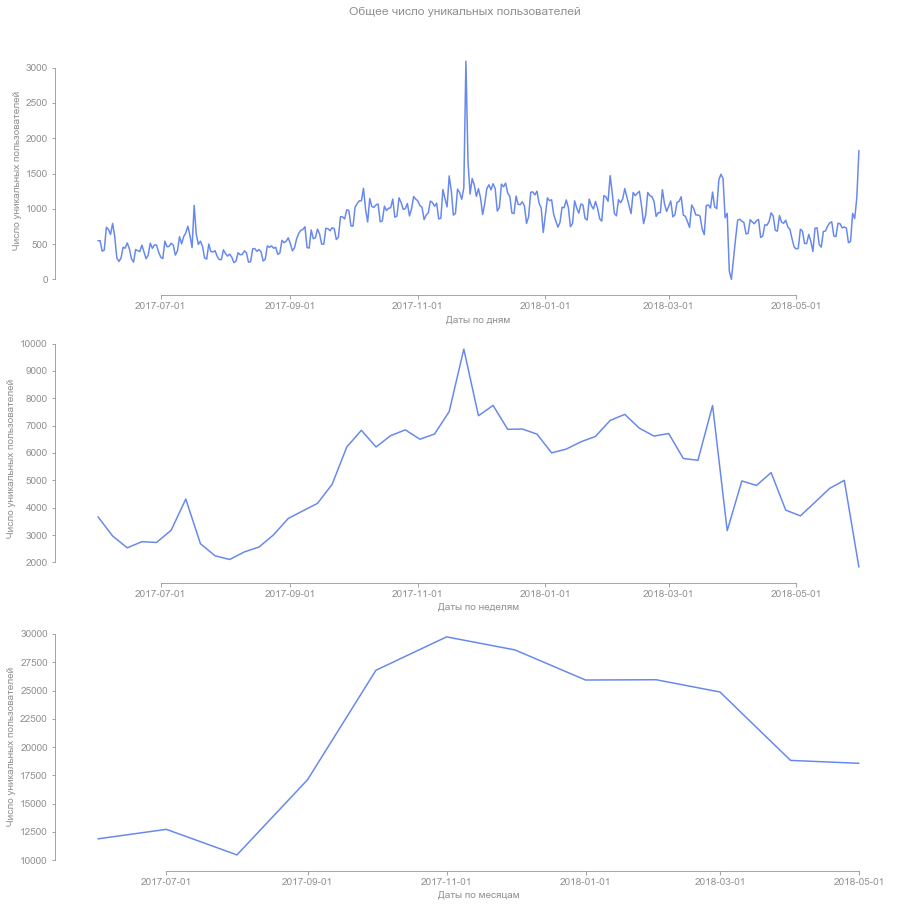

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
i = 0


for name, period in {'дням': 'datetime64[D]', 
                     'неделям': 'datetime64[W]', 
                     'месяцам': 'datetime64[M]'}.items():
    
    data = visits.groupby([visits['start_ts'].astype(period)]).agg({'uid': 'nunique'})
    print('Среднее число уникальных пользователей по '+name+': {:.0f}'.format(data.mean()[0]))
    
    lineplotting(data=data, 
                 values='uid', 
                 rawdata=False, 
                 ax=ax[i], 
                 xlabel='Даты по '+name, 
                 ylabel='Число уникальных пользователей')
    
    i += 1


plt.suptitle('Общее число уникальных пользователей', y=0.92) # общий заголовок для графиков
sns.despine(trim=True, offset=5) # настройки отображения осей

Напомним, что наблюдения охватывают календарный год, с 1 июня 2017 до 31 мая 2018. С переходом к более длительным периодам мы получаем сглаженные графики, по которым легче оценивать тенденцию на более длительных сроках.

На всех графиках наблюдаем, что есть всплески активности относительно ближайших дат во второй половине июля 2017 года и там же в марте 2018 года, а наиболее крупный пик активности приходится на ноябрь 2017, причем по дневной активности видно, что рост приходится на какой-то один день. Также есть заметное падение активности в апреле 2018 года. Более глобально число пользователей заметно возрастает осень и зимой, с уже упомянутым пиком в ноябре, далее весной за исключением пика в марте снижается.

Посмотрим, в какие именно дни происходят всплески и падения: 

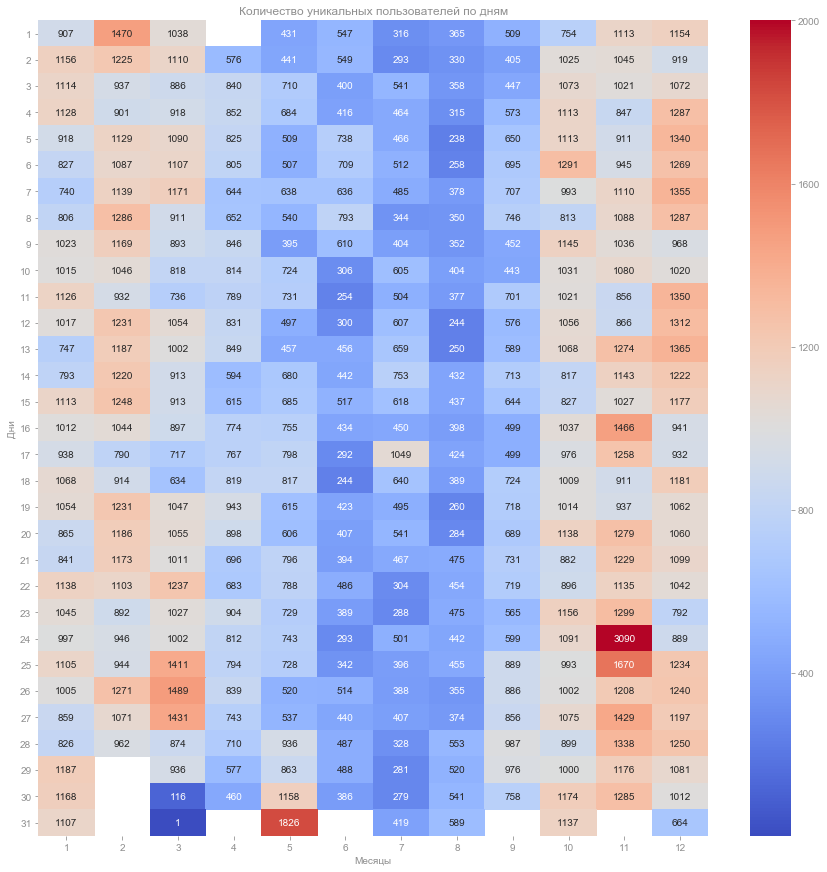

In [19]:
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(visits.pivot_table(index=visits['start_ts'].dt.day, 
                                         columns=visits['start_ts'].dt.month, 
                                         values='uid', 
                                         aggfunc='nunique'), 
                      cmap='coolwarm', 
                      vmax=2000, 
                      annot=True, 
                      fmt='.0f')

heatmap.set(xlabel='Месяцы', ylabel='Дни', title='Количество уникальных пользователей по дням')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0);

Пропуски в конце месяца связаны, конечно, с разной длиной месяца. А вот резкий провал в апреле — из-за отсутствующих сессий за 1 число, а также всего одного пользователя 31 марта. Или в эти дни никто категорически не интересовался билетами, или произошла ошибка в логах.

Всплеск активности в июле приходится на 17 число — количество пользователей превысило предыдущий день более чем в 2 раза. В марте перед провалом была высокая активность 25-27 числа. А самый заметный пик обеспечили 3090 уникальных пользователей 24 ноября 2017 года, что много даже на фоне высокой активности за весь месяц.

На тепловой карте также хорошо видно, что в целом уникальных пользователей на день меньше в летние месяцы, а осенью и зимой активность выше.

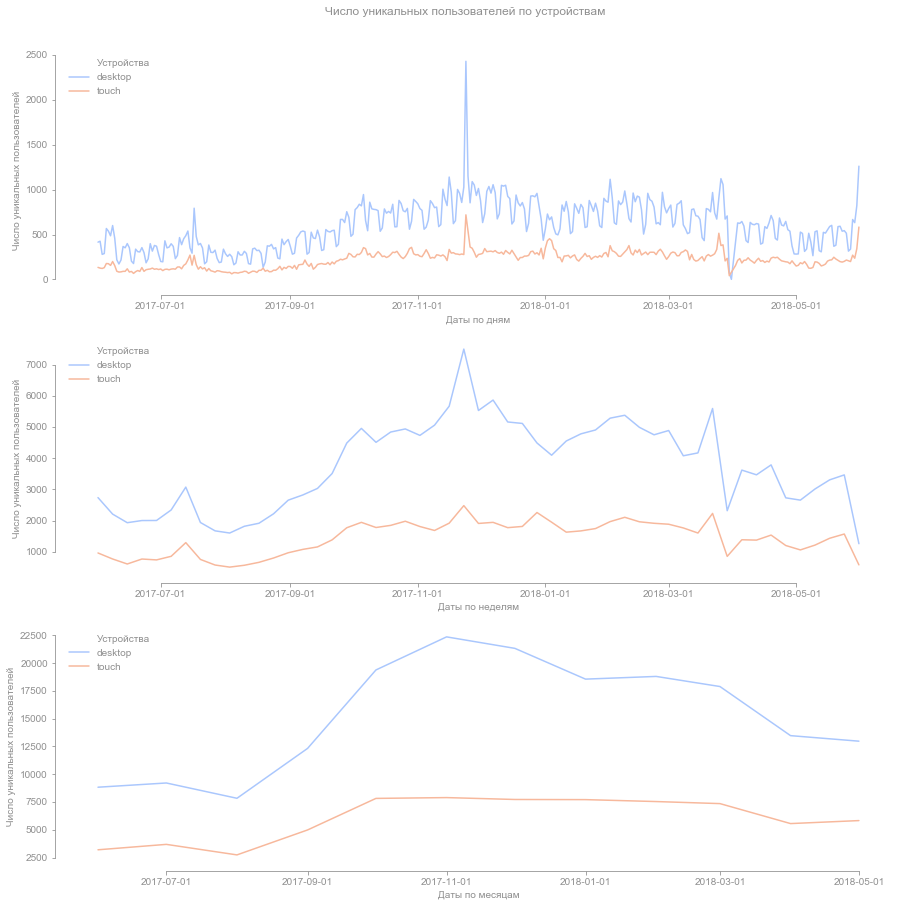

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
i = 0


for name, period in {'дням': 'datetime64[D]', 
                     'неделям': 'datetime64[W]', 
                     'месяцам': 'datetime64[M]'}.items():
    
    lineplotting(data=visits
                 .groupby([visits['start_ts'].astype(period), 'device'])
                 .agg({'uid': 'nunique'}), 
                 values='uid', 
                 withhue=True, 
                 rawdata=False, 
                 ax=ax[i], 
                 xlabel='Даты по '+name, 
                 ylabel='Число уникальных пользователей')
    
    ax[i].legend(loc=2).texts[0].set_text('Устройства')
    
    i += 1


plt.suptitle('Число уникальных пользователей по устройствам', y=0.92)
sns.despine(trim=True, offset=5)

Если рассматривать активность по устройствам, то динамика показателей значительно друг от друга не отличается, мы наблюдаем рост и падение сравнимо с общими показателями посещаемости, но больше уникальных пользователей заходят с десктопа, а не с мобильных устройств.

<a id='2012'></a>
#### Сколько сессий в день?

Рассчитаем количество сессий в день и рассмотрим показатель по дням, неделям и месяцам:

start_ts
2017-06-01    14774
2017-07-01    15993
2017-08-01    12912
2017-09-01    21492
2017-10-01    34097
2017-11-01    39795
2017-12-01    37908
2018-01-01    33304
2018-02-01    33548
2018-03-01    32207
2018-04-01    23731
2018-05-01    23843
Name: start_ts, dtype: int64

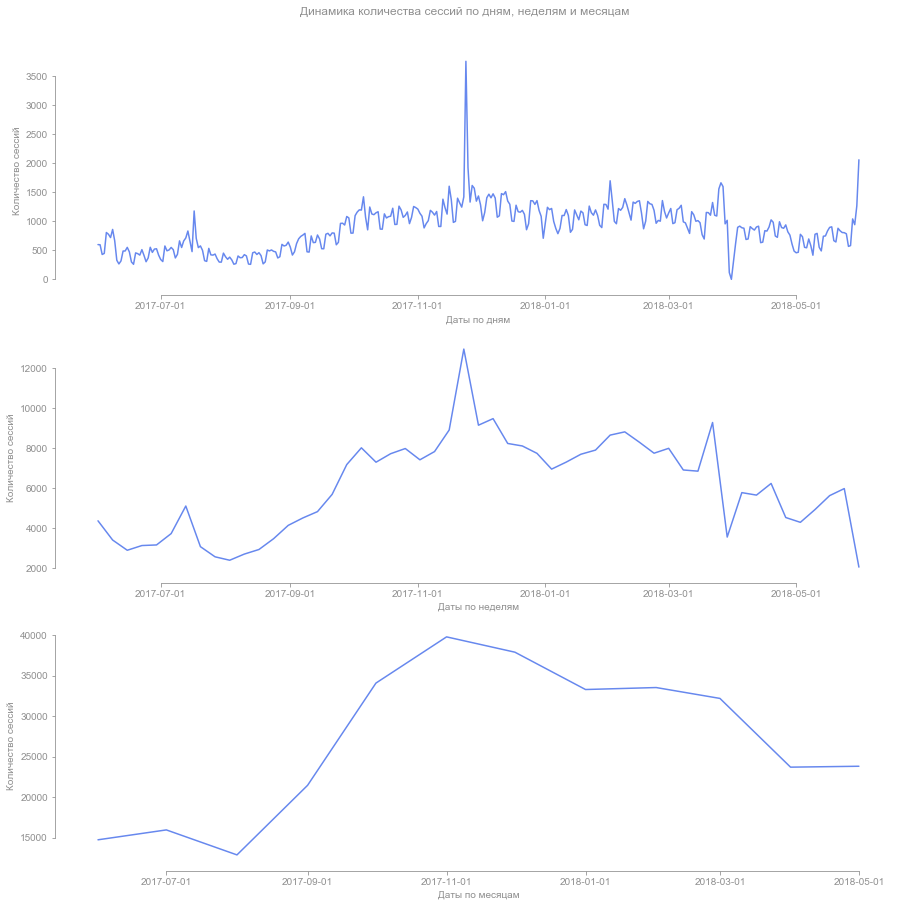

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
i = 0


for name, period in {'дням': 'datetime64[D]', 
                     'неделям': 'datetime64[W]', 
                     'месяцам': 'datetime64[M]'}.items():
    
    lineplotting(data=visits
                 .groupby([visits['start_ts'].astype(period)])
                 .agg(n_sessions=('start_ts', 'count')), 
                 values='n_sessions', 
                 rawdata=False, 
                 ax=ax[i], 
                 xlabel='Даты по '+name, 
                 ylabel='Количество сессий')
    
    i += 1


plt.suptitle('Динамика количества сессий по дням, неделям и месяцам', y=0.92)
sns.despine(trim=True, offset=5)

visits.groupby([visits['start_ts'].astype('datetime64[M]')])['start_ts'].count()

Здесь динамика ожидаемо схожа с количеством активных пользователей: также пик активности происходит в ноябре 2017, а провал — в конце марта-начале апреля 2018 года. С октября по март сессий больше.

Можем оценить, сколько в среднем приходится сессий на одного пользователя:

In [22]:
sessions_per_user = (visits
                     .groupby(visits['start_ts'].astype('datetime64[D]'))
                     .agg(n_sessions=('start_ts', 'count'), n_users=('uid', 'nunique'))
                     .reset_index())

sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user['sessions_per_user'].mean().round(3)

1.082

В среднем каждый пользователь заходит немного чаще одного раза в день — поэтому динамика схожа с количеством уникальных пользователей.

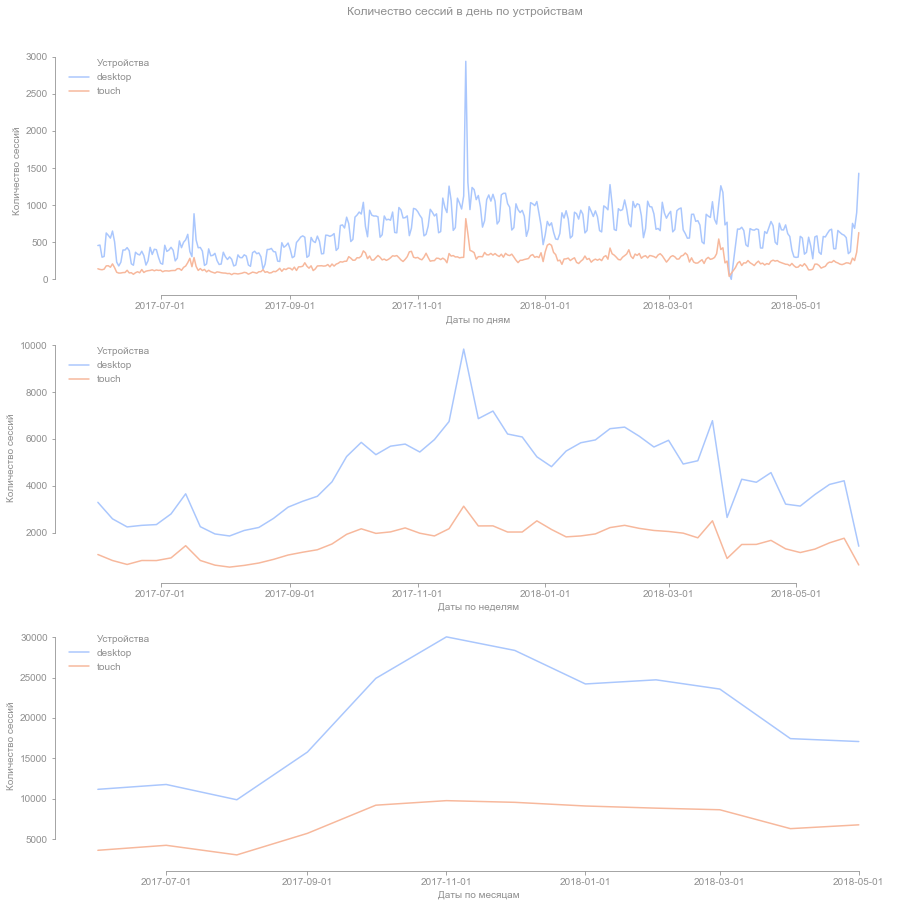

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
i = 0


for name, period in {'дням': 'datetime64[D]', 
                     'неделям': 'datetime64[W]', 
                     'месяцам': 'datetime64[M]'}.items():
    
    lineplotting(data=visits
                 .groupby([visits['start_ts'].astype(period), 'device'])
                 .agg(n_sessions=('start_ts', 'count')), 
                 values='n_sessions', 
                 withhue=True, 
                 rawdata=False, 
                 ax=ax[i], 
                 xlabel='Даты по '+name, 
                 ylabel='Количество сессий')
    
    ax[i].legend(loc=2).texts[0].set_text('Устройства')
    
    i += 1


plt.suptitle('Количество сессий в день по устройствам', y=0.92)
sns.despine(trim=True, offset=5)

По устройствам также заметно большая доля приходится на десктопы — похоже, люди больше предпочитают следить за событиями с полной версии сайта.

<a id='2013'></a>
#### Сколько длится одна сессия?

Посчитаем разницу между точным временем конца и начала сессий, выраженную в секундах и оценим распределение этого параметра:

count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: duration_sec, dtype: float64

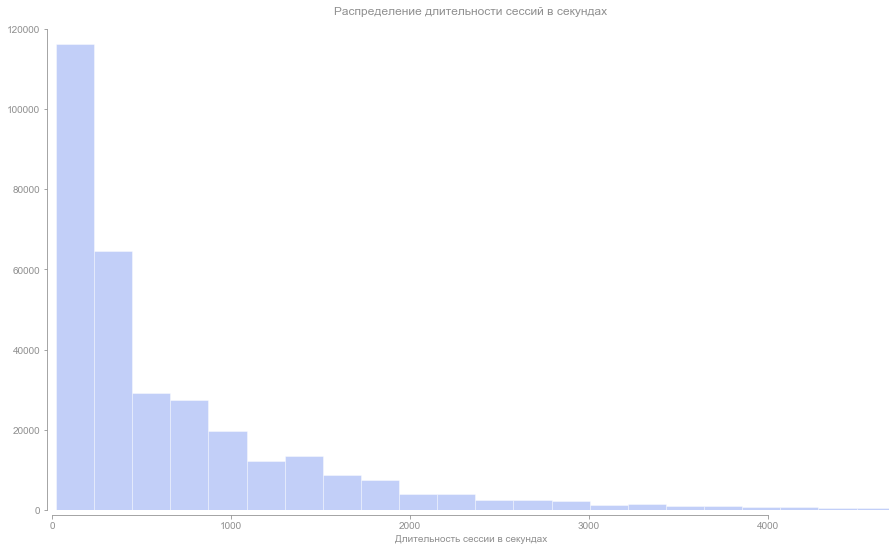

In [24]:
# посчитаем длительность каждой сессии
visits['duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

# построим гистограмму распределения duration_sec
(sns.distplot(visits['duration_sec'], kde=False, bins=200)
 .set(title='Распределение длительности сессий в секундах', 
      xlabel='Длительность сессии в секундах', 
      xlim=(0, visits['duration_sec'].quantile(.99))))
sns.despine(trim=True, offset=5)

# выведем описательные статистики duration_sec
visits['duration_sec'].describe()

In [25]:
# количество ультрадлинных сессий, превышающий 99-й процентиль
len(visits.loc[visits['duration_sec'] > visits['duration_sec'].quantile(.99), 'duration_sec'])

3149

Длина сессии (если мы не учитываем сессии с нулевой длительностью, которые отсекли на первом этапе) варьируется от 19 секунд до 11 часов и 51 минуты, но большинство сессий — до 15 минут. Показатель не распределен нормально, поэтому будем ориентироваться на медианное значение в качестве типичной длины сессии — она составляет 6 минут, большинство сессий длятся столько или короче. Далее с ростом длительности количество сессий падает. А ультрадлинных сессий (дольше 1 часа, 23 минут и 20 секунд) — совсем немного от общего количества, чуть больше 3 тысяч за год.

Принимая медианное значение как типичное, посмотрим на разницу в длительности по устройствам:

device
touch      240
desktop    420
Name: duration_sec, dtype: int64

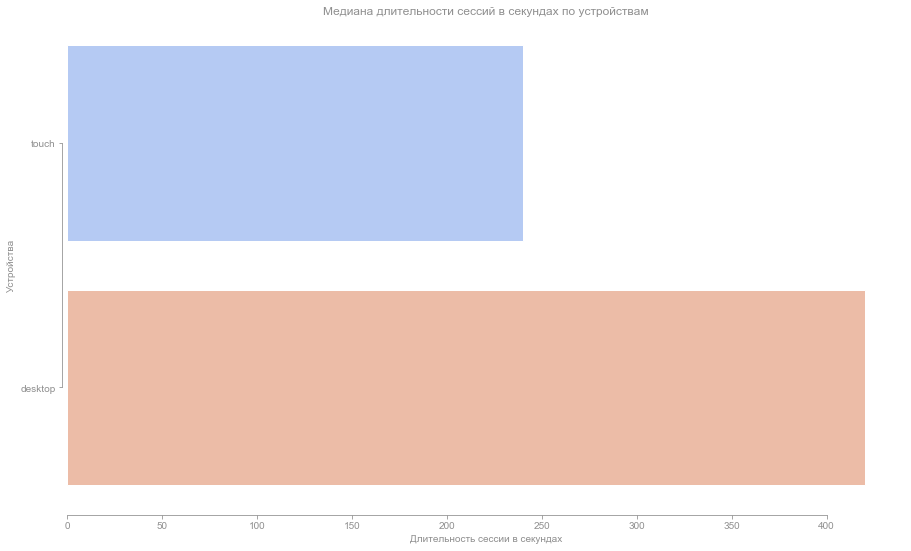

In [26]:
barplotting(data=visits.groupby('device').agg({'duration_sec': 'median'}), 
            values='duration_sec', 
            xlabel='Длительность сессии в секундах', 
            ylabel='Устройства', 
            title='Медиана длительности сессий в секундах по устройствам')

На полной версии сайта, с десктопов типичная сессия длится в 1,75 раз дольше.

<a id='2014'></a>
#### Как часто люди возвращаются?

Оценим, какой процент пользователей возвращается в последующие месяцы относительно первого месяца активности — для этого сделаем когортный анализ и изобразим результат в виде тепловой карты:

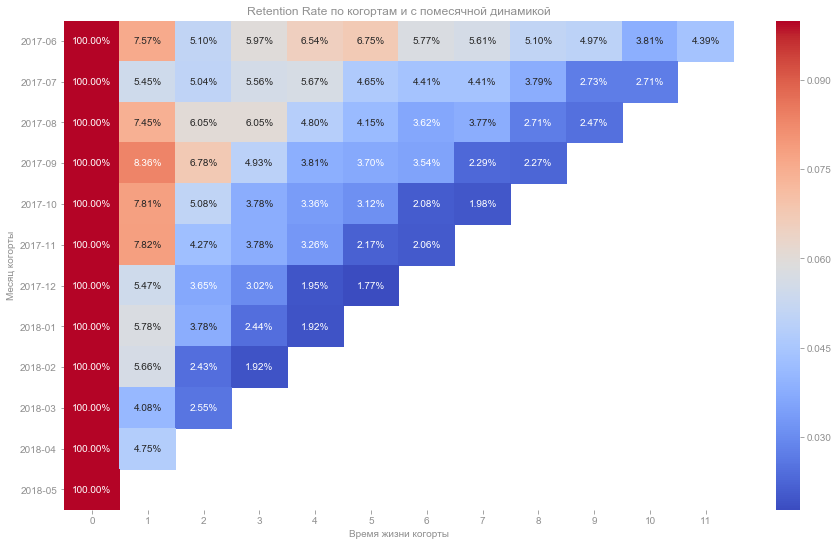

In [27]:
# строим когорты по месяцам с количеством уникальных пользователей
ret_cohorts = cohort_builder(data=visits, 
                             ts_column='start_ts', 
                             period='month', 
                             agg={'uid': 'nunique'})

# считаем показатель возвращаемости как отношение количества уникальных пользователей в месяц к размеру когорты
ret_cohorts['retention'] = ret_cohorts['uid'] / ret_cohorts['cohort_size']


# строим тепловую карту
cohorts_heatmapping(data=ret_cohorts, 
                    values='retention', 
                    aggfunc='sum', 
                    fmt='.2%', 
                    vmax=0.1, # ограничим верхнюю границу показателя, чтобы увидеть разницу после первого месяца
                    xlabel='Время жизни когорты', 
                    ylabel='Месяц когорты', 
                    title='Retention Rate по когортам и с помесячной динамикой')

По тепловой карте мы видим, что на любом времени жизни когорты повторно возвращаются не более 8,36% пользователей — это максимальный показатель, который встречается на первом месяце жизни когорты 2017-09 (учитывая, что месяц создания когорты — нулевой). Чаще всего лучшая возвращаемость демонстрируется на первом месяце, после она падает; последние месяцы в основном самые низкие. Относительно хорошо себя показывает когорта 2017-06, все держится на среднем уровне, без больших провалов, а возвращаемость на 3, 4 и 5 месяце даже растет.

cohort_lifetime
0     100.00%
1       6.38%
2       4.47%
3       4.16%
4       3.91%
5       3.76%
6       3.58%
7       3.61%
8       3.47%
9       3.39%
10      3.26%
11      4.39%
Name: retention, dtype: object

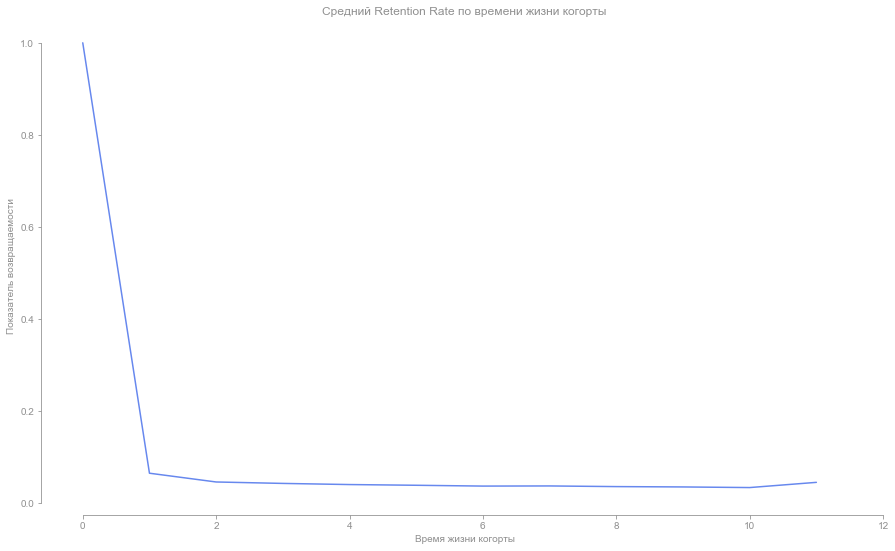

In [28]:
# построим график среднего retention rate по месячным когортам
lineplotting(data=ret_cohorts
             .groupby('cohort_lifetime')
             .agg({'retention': 'mean'}), 
             values='retention', 
             percents=True, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Показатель возвращаемости', 
             title='Средний Retention Rate по времени жизни когорты')

В среднем в течение жизни когорты процент возвращаемости стабильно падает начиная с 6,38% в первый месяц, только немного подрастает на 11 месяце — но здесь у нас данные только по одной когорте.

Рассмотрим также динамику среднего retention rate по устройствам и источникам сессий:

device,desktop,touch
cohort_lifetime,,
0,100.00%,100.00%
1,6.69%,5.96%
2,4.73%,4.07%
3,4.45%,3.69%
4,4.23%,3.39%
5,4.14%,3.13%
6,3.86%,3.15%
7,3.89%,3.09%
8,3.78%,2.97%


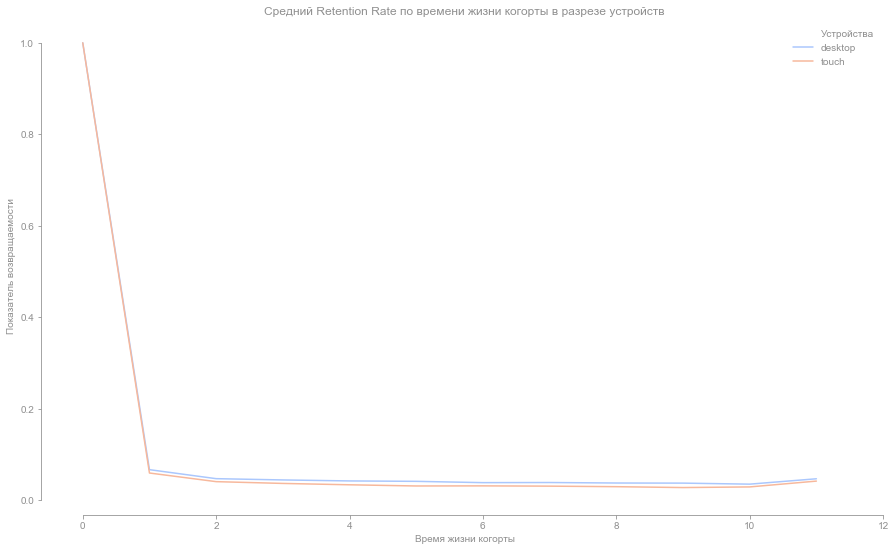

In [29]:
# формируем месячные когорты с учетом устройств, считаем возвращаемость
ret_cohorts_by_device = cohort_builder(data=visits, 
                                       ts_column='start_ts', 
                                       grouper='device', 
                                       period='month', # указываем дополнительную группирующую переменную
                                       agg={'uid': 'nunique'})

ret_cohorts_by_device['retention'] = ret_cohorts_by_device['uid'] / ret_cohorts_by_device['cohort_size']


# строим линейный график с разбивкой по устройствам
lineplotting(data=ret_cohorts_by_device
             .groupby(['cohort_lifetime', 'device'])
             .agg({'retention': 'mean'}), 
             values='retention', 
             withhue=True, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Показатель возвращаемости', 
             title='Средний Retention Rate по времени жизни когорты в разрезе устройств')

plt.legend().texts[0].set_text('Устройства') # переименуем заголовок легенды


# выведем исходные данные, по которым был построен график
ret_cohorts_by_device.pivot_table(index='cohort_lifetime', 
                                  columns='device', 
                                  values='retention', 
                                  aggfunc='mean').applymap('{:.2%}'.format).replace('nan%', '')

Здесь динамика сравнима с общей, а для десктопов этот показатель немного выше, чем для мобильных устройств.

source_id,1,2,3,4,5,9,10
cohort_lifetime,,,,,,,
0,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
1,14.14%,16.18%,4.51%,6.71%,4.49%,16.75%,5.37%
2,8.23%,11.04%,3.39%,4.86%,3.00%,14.49%,2.96%
3,7.75%,9.87%,3.61%,4.62%,2.60%,11.48%,2.84%
4,7.74%,9.28%,3.32%,4.49%,2.23%,11.32%,3.53%
5,7.33%,8.66%,3.18%,4.63%,2.32%,9.98%,2.17%
6,6.95%,8.91%,3.10%,4.26%,1.95%,8.50%,2.19%
7,7.38%,8.40%,3.13%,4.22%,2.00%,8.42%,3.77%
8,6.36%,8.44%,3.05%,4.23%,1.99%,8.55%,4.36%


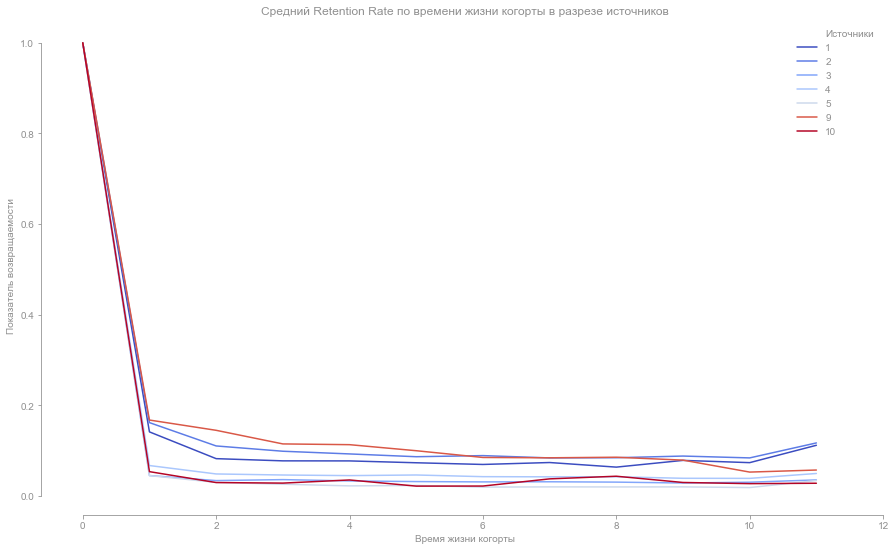

In [30]:
# формируем месячные когорты с учетом источников сессий, 
# исключаем 6 и 7 источник — там мало пользователей и сессий, данные нерелевантны для сравнения
ret_cohorts_by_source = cohort_builder(data=visits, 
                                       ts_column='start_ts', 
                                       grouper='source_id', 
                                       period='month', 
                                       agg={'uid': 'nunique'}).query('source_id != 6 and source_id != 7')

# считаем возвращаемость
ret_cohorts_by_source['retention'] = ret_cohorts_by_source['uid'] / ret_cohorts_by_source['cohort_size']


# строим график
lineplotting(data=ret_cohorts_by_source
             .groupby(['cohort_lifetime', 'source_id'])
             .agg({'retention': 'mean'}), 
             values='retention', 
             withhue=True, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Показатель возвращаемости', 
             title='Средний Retention Rate по времени жизни когорты в разрезе источников')

plt.legend().texts[0].set_text('Источники')


# выведем исходные данные, по которым был построен график
ret_cohorts_by_source.pivot_table(index='cohort_lifetime', 
                                  columns='source_id', 
                                  values='retention', 
                                  aggfunc='mean').applymap('{:.2%}'.format).replace('nan%', '')

В разрезе по источникам также сохраняется общая динамика; лучшие показатели посещаемости — у источников 1 и 2.

<a id='2015'></a>
#### Выводы из анализа продуктовых метрик


1. **Пользовательская активность**:
    - В среднем в день заходят 818 уникальных пользователей, в неделю — 5 156, в месяц — 20 956.
    - За наблюдаемый период пользовательская активность была выше всю осень и зиму, со стабильным ростом в течение всего сентября и половины октября и пиком в ноябре, а с марта активность снижалась. Это можно объяснить значительно большим количеством культурных событий осенью и зимой, особенно под конец года — в это время происходит много театральных и кинопремьер, заметных выставок, концертов.
    - Самые низкие значения — в летние месяцы. Можно предположить, что это совпадает с сезоном отпусков, который многие жители Москвы и Санкт-Петербурга проводят не в своих городах, и меньшей плотностью событий в эти месяцы: например, крупные в масштабе года кинорелизы редко выпускают летом, а те же театры завершают сезоны до осени. 
    - Кроме помесячной тенденции, есть отдельные даты, одна или несколько подряд, которые отвечают за резкие всплески активности на фоне остального месяца: такие были в марте, мае, июле и ноябре. Это также может следовать за отдельными особенно популярными событиями, которые вызывают больше интереса.
    - В разрезе устройств заметно больше уникальных пользователей заходят с десктопов. Динамика активности для обеих платформ сходна с общей.


2. **Количество сессий в день**:
    - На одного уникального пользователя приходится в среднем 1,08 сессий, поэтому динамика числа сессий похожа на динамику активности: с октября по март сессий больше, а в летние месяцы меньше; пик — в ноябре, а в конце марта-начале апреля провал.
    - Среди устройств также большая доля приходится на десктопы.


3. **Длина одной сессии**:
    - Большинство сессий попали в диапазон от 19 секунд до 15 минут, с медианой в 6 минут. Значительный перевес в сторону именно коротких сессий, поэтому можем считать за наиболее частые сессии длительностью в пределах 6 минут.
    - На десктопах типичные сессии длятся в 1,75 раз дольше, чем на мобильных устройствах.


4. **Показатели возвращаемости (Retention Rate)**:
    - Retention Rate для всех когорт и в течение всего времени жизни не превысил 8,36%. Больше показатели возвращаемости на 1-м месяце жизни, далее процент обычно падает и ниже всего — на последних месяцах. Относительно хорошо себя показывает когорта 2017-06: показатели на среднем уровне, без больших провалов, а на 3-м, 4-м и 5-м месяцах жизни они даже растут (это осенние месяцы).
    - Если усреднить Retention Rate, в течение жизни когорты процент возвращаемости стабильно падает начиная с 6,38% в 1-й месяц.
    - Среди устройств разница показателя не сильно отличается, но у десктопов проценты немного выше.
    - Лучшие проценты возвращаемости среди источников — у 1 и 2.

<a id='202'></a>
### Метрики продаж

В данную группу метрик входит время до первого заказа, количество заказов в день, неделю и месяц, средний чек и LTV; каждую метрику релевантно также будет рассмотреть в разрезе устройств и источников сессий, которые привели к заказам: процессы заказа на полной и мобильной версиях сайта или в приложении различаются, и как мы выяснили, на разных устройствах люди проводят разное количество времени. А распределение по устройствам важно для сопоставления с маркетинговыми затратами.

Для некоторых метрик нам также понадобится информация о сессиях покупателей, поэтому присоединим эти данные к таблице с заказами:

In [31]:
# соединяем сессии с заказами и данные о заказах, включаем только первый источник входа на сайт
orders = orders.join(visits
                     .sort_values(by='start_ts')
                     .groupby('uid') # группируем по uid
                     .agg({'source_id': 'first', # включаем первый источник входа
                           'device': 'first', # включаем первое устройство для входной сессии
                           'start_ts': 'min'}), # включаем дату входной сессии
                     on='uid', how='inner')

orders = orders.query('buy_ts > start_ts') # без некорректных значений

orders

,buy_ts,revenue,uid,source_id,device,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,desktop,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,desktop,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,desktop,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,desktop,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,desktop,2017-06-01 07:31:00
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,4,touch,2018-05-31 09:11:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,10,desktop,2018-05-31 23:05:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,3,desktop,2018-05-31 23:52:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,3,desktop,2017-10-23 12:32:00


<a id='2021'></a>
#### Сколько времени проходит до первой покупки?

Определим время до первой покупки как разницу между датой первой сессии, которую мы получили после присоединения таблицы с сессиями, и датой заказа, выраженную в минутах. Посмотрим, как распределен этот показатель:

count    47311.000000
mean       367.728562
std        486.909042
min          1.000000
25%          8.000000
50%         75.000000
75%        684.000000
max       1439.000000
Name: minutes_before_buy, dtype: float64

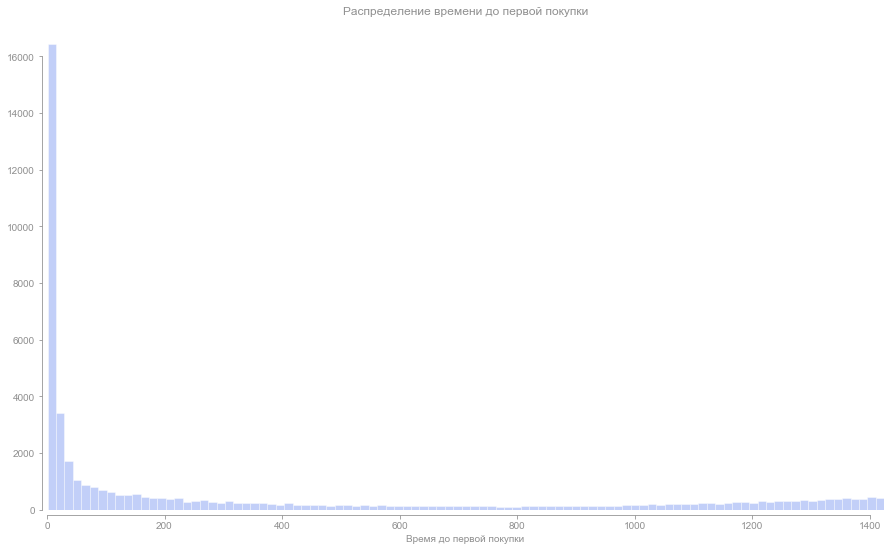

In [32]:
# посчитаем количество минут между датой первой сессии и датой покупки
orders['minutes_before_buy'] = (orders['buy_ts'] - orders['start_ts']).dt.seconds / 60
minutes_before_buy = orders[orders['minutes_before_buy'] > 0] # рассмотрим только ненулевые показатели

# построим гистограмму распределения minutes_before_buy
(sns.distplot(minutes_before_buy['minutes_before_buy'], kde=False, bins=100)
 .set(title='Распределение времени до первой покупки', 
      xlabel='Время до первой покупки', 
      xlim=(0, minutes_before_buy['minutes_before_buy'].quantile(.99))))
sns.despine(trim=True, offset=5)

# выведем описательные статистики minutes_before_buy
minutes_before_buy['minutes_before_buy'].describe()

Большинство значений лежат в диапазоне от 8 минут до 11 часов и 24 минут, это большой размах, но все же в основном люди совершают «быстрые» покупки — данные не распределены нормально, большой пик в начале гистограммы, где время приближено к минимальной одной минуте до заказа. Можем заключить, что типичное время до первой покупки — в пределах 1 часа и 15 минут.

device
desktop     66.0
touch      136.0
Name: minutes_before_buy, dtype: float64

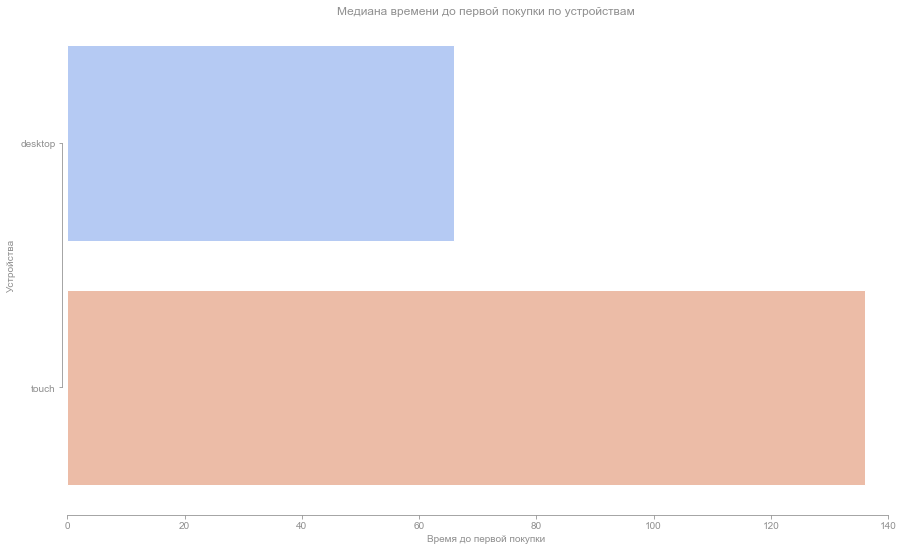

In [33]:
barplotting(data=minutes_before_buy.groupby('device')['minutes_before_buy'].median(), 
            values='minutes_before_buy', 
            xlabel='Время до первой покупки', 
            ylabel='Устройства', 
            title='Медиана времени до первой покупки по устройствам')

В разрезе по устройствам типичное время до первой покупки на десктопе — в пределах 1 часа и 6 минут, а на мобильных устройствах — 2 часов и 16 минут, т.е. пользователи десктопа тратят меньше времени до первой покупки.

source_id
10     21.0
5      44.0
4      45.0
7      52.0
3      54.0
1     137.0
2     203.0
9     291.0
Name: minutes_before_buy, dtype: float64

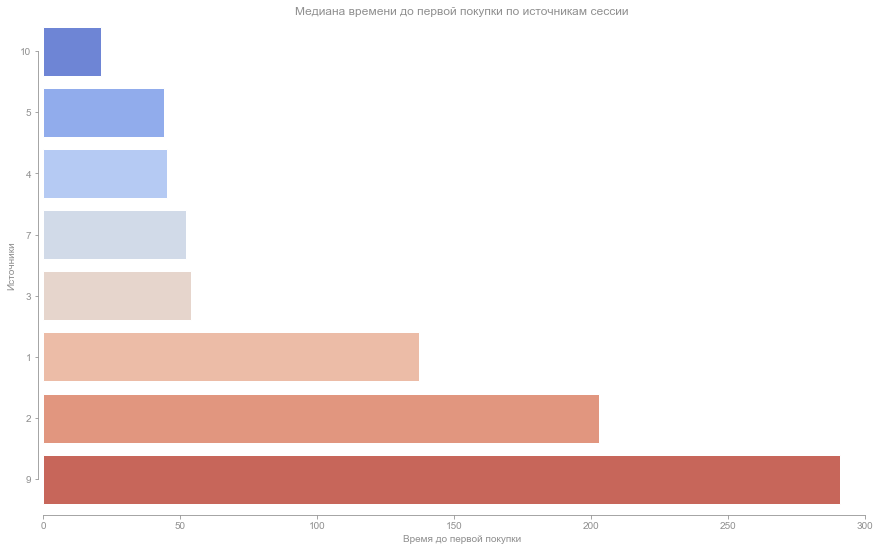

In [34]:
barplotting(data=minutes_before_buy.groupby('source_id')['minutes_before_buy'].median(), 
            values='minutes_before_buy', 
            xlabel='Время до первой покупки', 
            ylabel='Источники', 
            title='Медиана времени до первой покупки по источникам сессии')

В разрезе по источникам быстрее всего с покупкой справляются пользователи, пришедшие из источника 10 (21 минута), а дольше всего — из источника 9 (4 часа 51 минута).

<a id='2022'></a>
#### Сколько раз покупают за период?

Для ответа на этот вопрос посчитаем количество уникальных дат в таблице о заказах, т.к. каждая запись в этой таблице равна факту покупки. Распределим показатель по дням, неделям и месяцам, рассмотрим динамику по когортам, оценим различия по устройствам и источникам.

Среднее число заказов по дням: 119
Среднее число заказов по неделям: 819
Среднее число заказов по месяцам: 3339


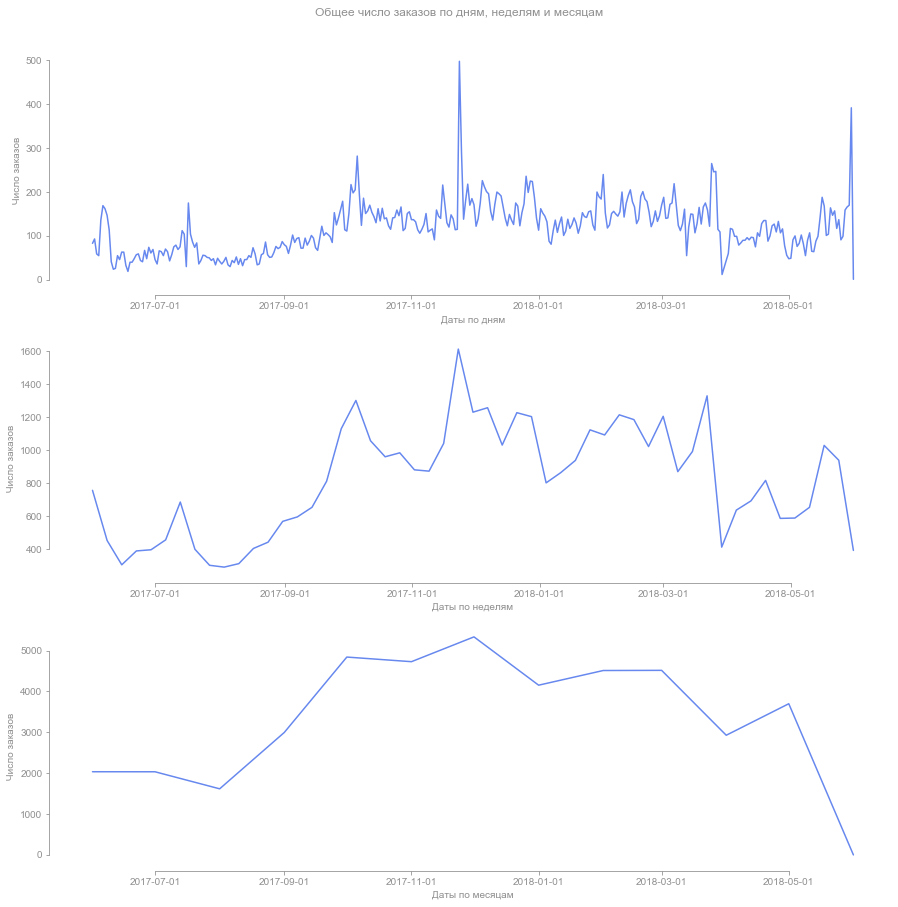

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
i = 0


for name, period in {'дням': 'datetime64[D]', 
                     'неделям': 'datetime64[W]', 
                     'месяцам': 'datetime64[M]'}.items():
    
    data = orders.groupby([orders['buy_ts'].astype(period)]).agg({'buy_ts': 'nunique'})
    print('Среднее число заказов по '+name+': {:.0f}'.format(data.mean()[0]))
    
    lineplotting(data=data, 
                 values='buy_ts', 
                 rawdata=False, 
                 ax=ax[i], 
                 xlabel='Даты по '+name, 
                 ylabel='Число заказов')
    
    i += 1


plt.suptitle('Общее число заказов по дням, неделям и месяцам', y=0.92)
sns.despine(trim=True, offset=5)

В более краткой перспективе мы замечаем заметные всплески в количестве заказов в начале октября и в конце марта, апреля и ноября. По месяцам — больше заказывают с октября по март, а ещё в мае, что в общем-то совпадает и с динамикой пользовательской активности.

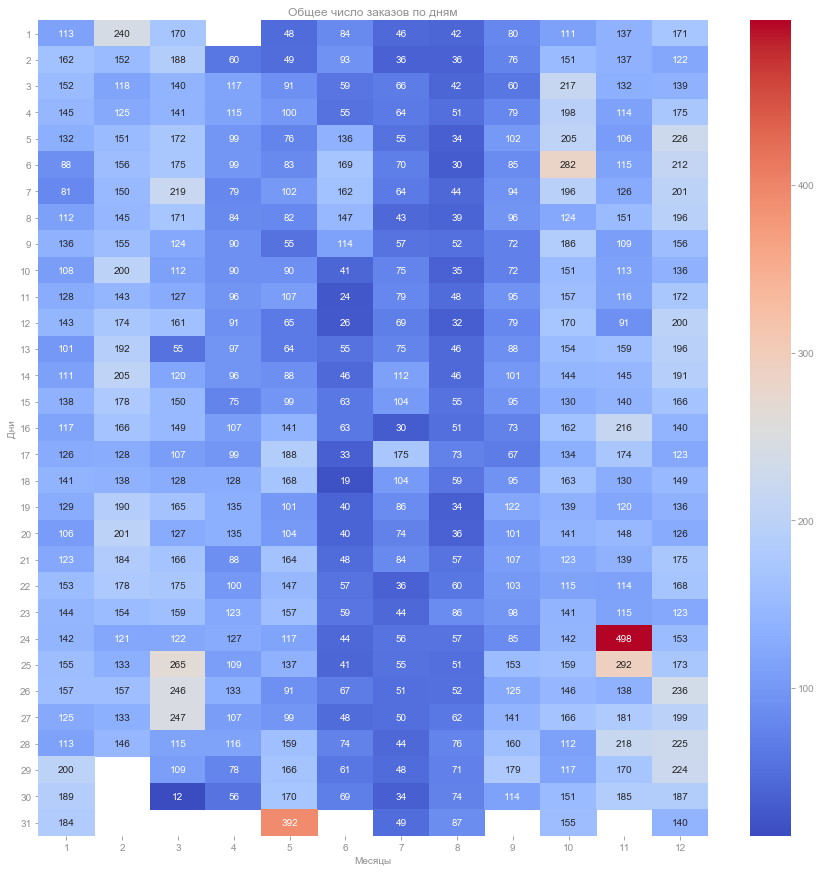

In [36]:
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(orders.pivot_table(index=orders['buy_ts'].dt.day, 
                                         columns=orders['buy_ts'].dt.month, 
                                         values='buy_ts', 
                                         aggfunc='nunique'), 
                      cmap='coolwarm', 
                      annot=True, 
                      fmt='.0f')

heatmap.set(xlabel='Месяцы', ylabel='Дни', title='Общее число заказов по дням')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0);

Как уже было отмечено, в ежедневной перспективе особенно выделяются 25-27 марта (больше среднего по месяцу примерно в 1,7 раз), 31 апреля (больше среднего по месяцу в 3,3 раза), 6 октября (в 1,8 раза) и 24 ноября (в 3,2 раза).

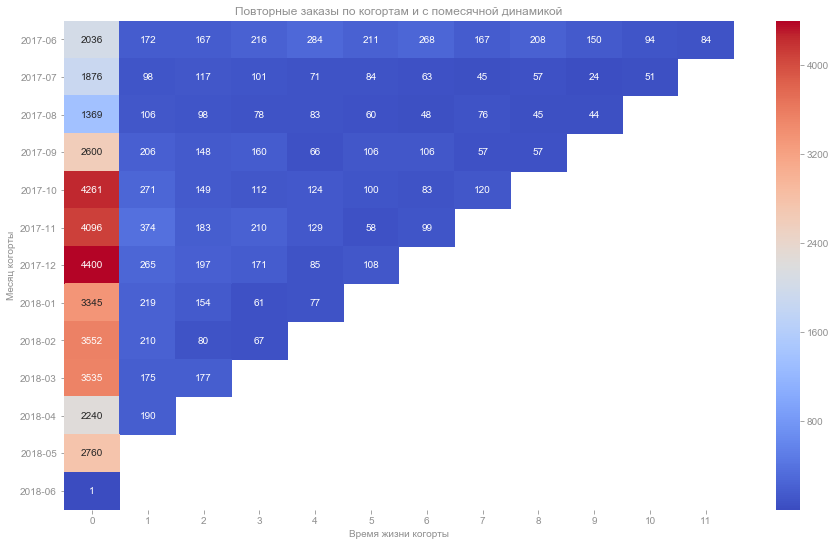

In [37]:
cohorts_heatmapping(data=cohort_builder(data=orders,
                                        ts_column='buy_ts',
                                        period='month',
                                        agg={'buy_ts': 'nunique'}), 
                    values='buy_ts', 
                    aggfunc='sum', 
                    fmt='.0f', 
                    xlabel='Время жизни когорты', 
                    ylabel='Месяц когорты', 
                    title='Повторные заказы по когортам и с помесячной динамикой')

В данном случае мы по сути оцениваем объем повторных заказов когорты — и здесь ясно видно, что большинство заказов всё-таки совершаются в нулевой месяц когорты, т.е. за наблюдаемый период объем повторных заказов в рамках выделенных когорт низок. Как мы и видели в месячной динамике, больше всего заказов было сделано в октябре-декабре 2017.

device
touch       8604
desktop    35920
Name: buy_ts, dtype: int64

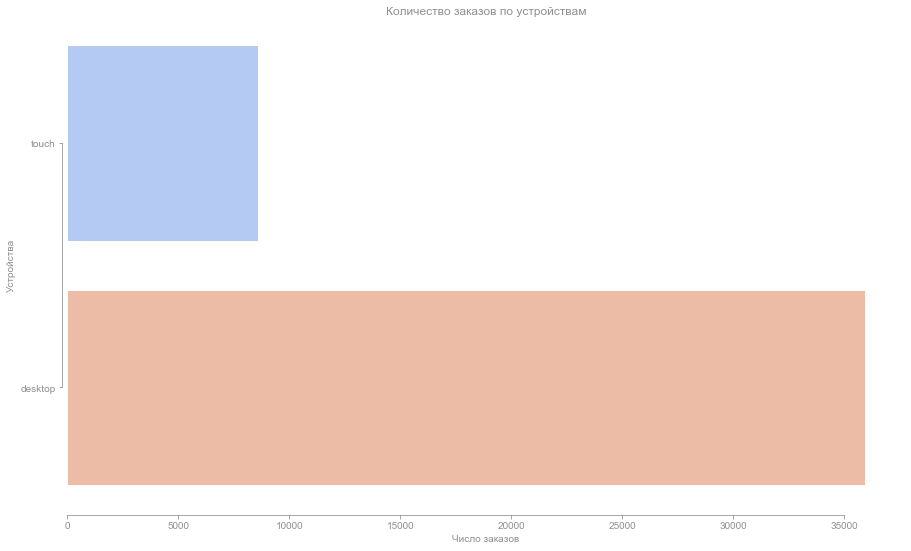

In [38]:
barplotting(data=orders.groupby('device')['buy_ts'].nunique(), 
            values='buy_ts', 
            xlabel='Число заказов', 
            ylabel='Устройства', 
            title='Количество заказов по устройствам')

По устройствам снова впереди десктоп, который обгоняет по количеству заказов мобильные устройства более чем в 4 раза.

source_id
7         1
10     1461
9      1585
1      4672
2      5966
5      8770
4     11901
3     12099
Name: buy_ts, dtype: int64

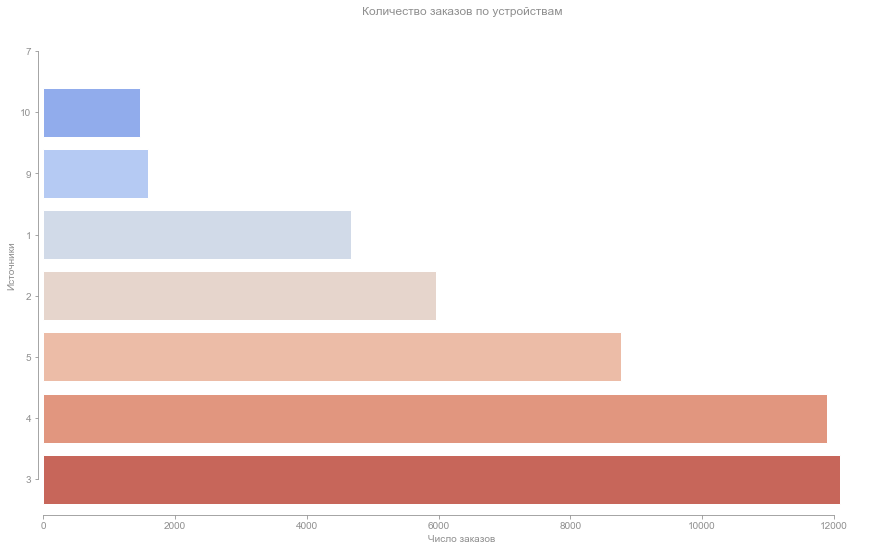

In [39]:
barplotting(data=orders.groupby('source_id')['buy_ts'].nunique(), 
            values='buy_ts', 
            xlabel='Число заказов', 
            ylabel='Источники', 
            title='Количество заказов по устройствам')

С источника 7 был сделан всего один заказ за год, его сравнивать нерелевантно. Исключая этот источник, меньше всего заказов было сделано с 9 и 10 источника (количественно они близки, поэтому упомянем оба), а больше всего — с 3 и 4 источника (также). Разрыв между наибольшим и наименьшим источником — более чем в 8 раз.

<a id='2023'></a>
#### Какой средний чек?

Здесь мы рассмотрим среднюю выручку, суммированную по дням, неделям и месяцам, а также динамику этого показателя по когортам.

Усредненная выручка по дням: 660
Усредненная выручка по неделям: 4533
Усредненная выручка по месяцам: 18482


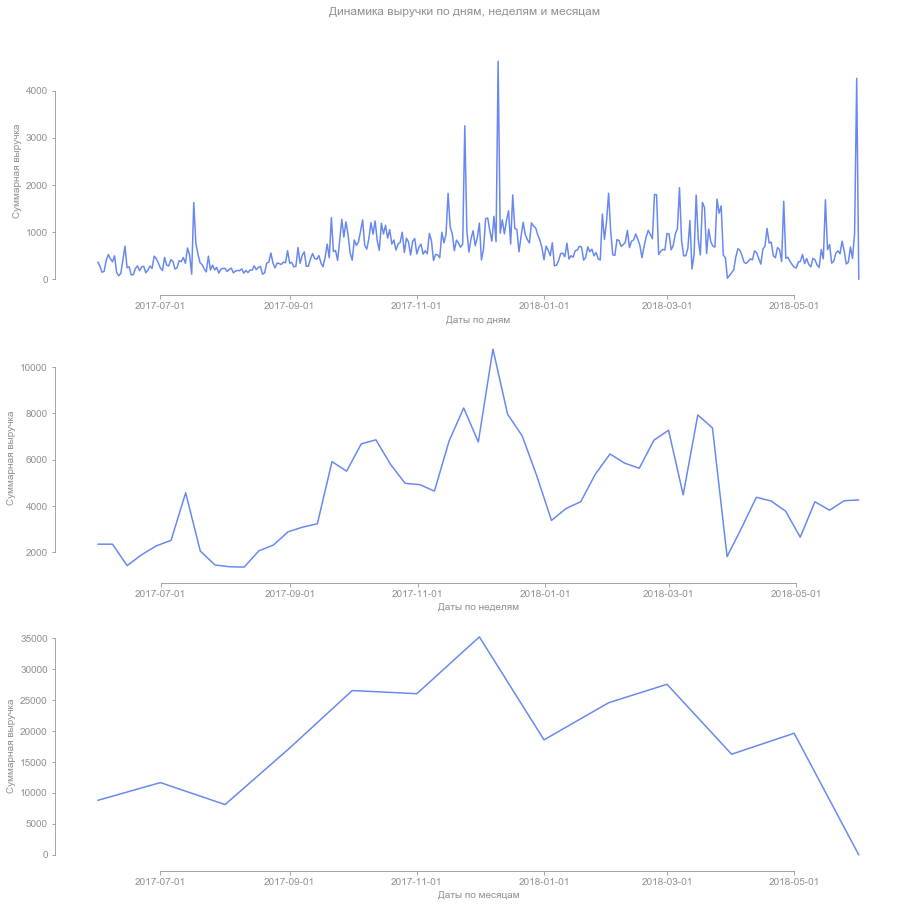

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
i = 0


for name, period in {'дням': 'datetime64[D]', 
                     'неделям': 'datetime64[W]', 
                     'месяцам': 'datetime64[M]'}.items():
    
    data = orders.groupby([orders['buy_ts'].astype(period)]).agg({'revenue': 'sum'})
    print('Усредненная выручка по '+name+': {:.0f}'.format(data.mean()[0]))
    
    lineplotting(data=data, 
                 values='revenue', 
                 rawdata=False, 
                 ax=ax[i], 
                 xlabel='Даты по '+name, 
                 ylabel='Суммарная выручка')
    
    i += 1


plt.suptitle('Динамика выручки по дням, неделям и месяцам', y=0.92)
sns.despine(trim=True, offset=5);

Самое важное, что обращает на себя внимание — есть некоторые расхождения с динамикой показателей активности и количества заказов. В краткой перспективе мы видим уже привычные пиковые значения в ноябре, марте апреле и мае. Но наибольший пик по выручке приходится на декабрь при сравнительно меньшей активности в заказах — значит, в декабре были сделаны более дорогие заказы. Также были сравнительно успешные по выручке дни в феврале и июле. 

Месячная динамика снова показывает большую выручку в октябре-декабре и дополнительный рост в марте. Но в январе суммарная выручка проседает, а количество заказов — нет. Т.е. в январе совершались менее дорогие заказы.

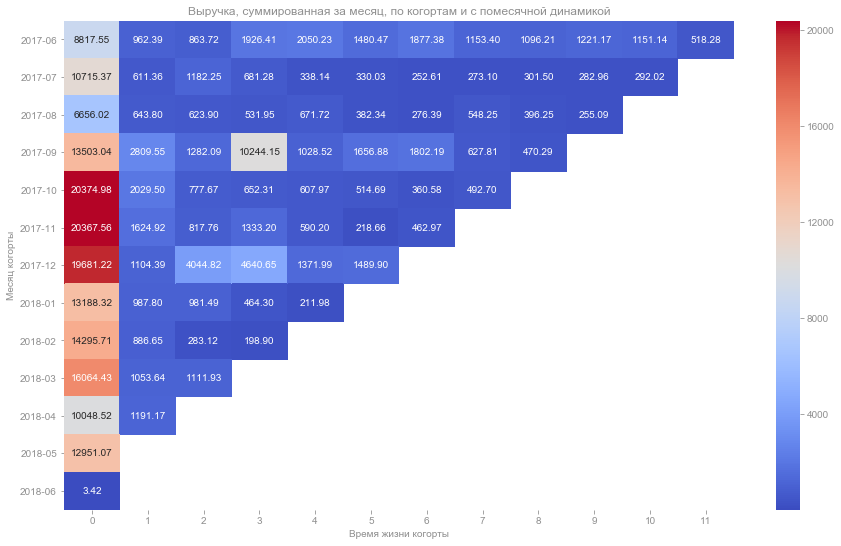

In [41]:
cohorts_heatmapping(data=cohort_builder(data=orders, 
                                        ts_column='buy_ts', 
                                        period='month', 
                                        agg={'revenue': 'sum'}), 
                    values='revenue', 
                    aggfunc='mean', 
                    xlabel='Время жизни когорты', 
                    ylabel='Месяц когорты', 
                    title='Выручка, суммированная за месяц, по когортам и с помесячной динамикой')

Также, как мы и видели в количестве заказов, больше всего суммарной выручки приходится на нулевой месяц жизни когорты — т.к. повторных заказов относительно немного. Однако есть исключение — в когорте 2017-09 хорошая сумма выручки пришлась на третий месяц жизни; это заказы, сделанные в декабре 2017 (это же наблюдаем на графике). По некой причине дополнительно удалось привлечь для повторных покупок именно эту когорту. Самыми успешными же по суммарной выручке в первый месяц оказались когорты октября-декабря, сделавшие также больше заказов — суммарная выручка в нулевой месяц жизни превысила среднюю месячную выручку.

<a id='2024'></a>
#### Сколько денег приносят?

Высчитаем показатель LTV по когортам, устройствам и источникам — этот итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. LTV позволит нам оценить, сколько денег приходится на каждого покупателя в зависимости от когорт, в дальнейшем сравним его с маркетинговыми затратами для оценки эффективности привлечения клиентов.

Считаем LTV из валовой прибыли, умножая выручку на показатель маржинальности. Однако в данном случае нам достоверно неизвестна маржинальность наших услуг, поэтому принимаем ее за 100% или за единицу. При уточнении маржинальности можно будет скорректировать наши расчеты. 

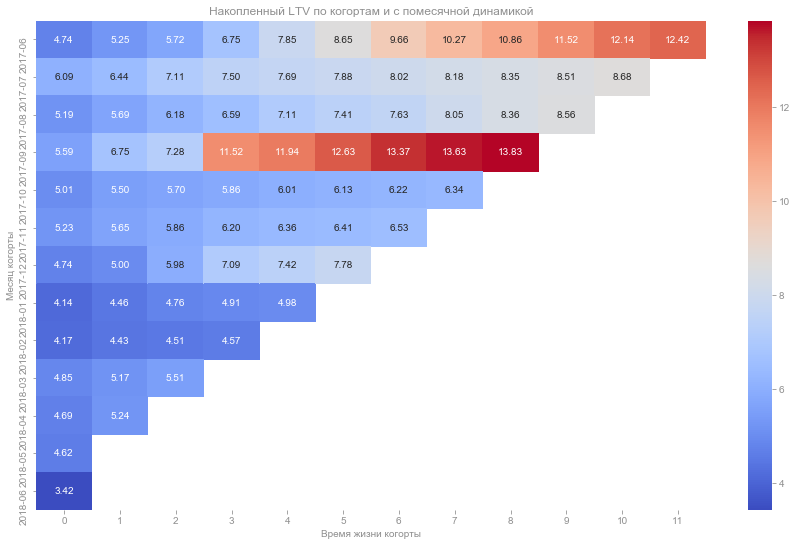

In [42]:
# соединим число уникальных пользователей и помесячную выручку для каждой когорты
ltv_cohorts = cohort_builder(data=orders, 
                             ts_column='buy_ts', 
                             period='month', 
                             agg={'revenue': 'sum', 'uid': 'nunique'})

# рассчитаем LTV как отношение валовой прибыли за месяц к размеру соответствующей когорты
margin_rate = 1
ltv_cohorts['ltv'] = ltv_cohorts['revenue'] * margin_rate / ltv_cohorts['cohort_size']


# построим сводную таблицу и посчитаем накопленную сумму
ltv_pivot = ltv_cohorts.pivot(index='first_month', columns='cohort_lifetime', values='ltv').cumsum(axis=1)
ltv_pivot.index = ltv_pivot.index.strftime('%Y-%m')


# изобразим результат на тепловой карте
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', cmap='coolwarm').set(
    xlabel='Время жизни когорты', ylabel='Месяц когорты', 
    title='Накопленный LTV по когортам и с помесячной динамикой');

По тепловой карте с накопленный LTV мы видим, что лучше всех себя показала когорта 2017-09 — к третьему месяцу жизни (декабрю) каждый пользователь когорты приносит 11,52 денег. К примеру, вторая по прибыльности когорта 2017-06 достигает такого же уровня только к девятому месяцу жизни (марту). Остальные показали средний результат или ниже среднего.


Оценим LTV для каждого времени жизни когорты — для этого усредним накопленные суммы для каждой когорты. Так мы поймем, сколько в среднем пользователь приносит денег на каждом этапе жизни когорты.

cohort_lifetime
0      4.81
1      5.42
2      5.86
3      6.78
4      7.42
5      8.13
6      8.57
7      9.30
8     10.35
9      9.53
10    10.41
11    12.42
dtype: float64

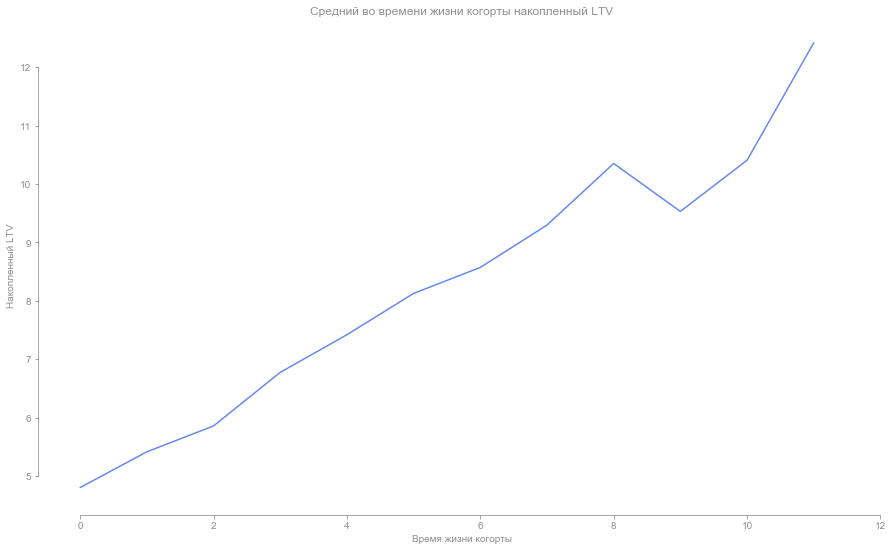

In [43]:
# отразим средний накопленный LTV на линейном графике
lineplotting(data=ltv_pivot.mean(), 
             values=ltv_pivot.mean().values, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Накопленный LTV', 
             title='Средний во времени жизни когорты накопленный LTV')


# выведем исходные данные, по которым построен график
ltv_pivot.mean().round(2)

Накопленный LTV мы в дальнейшем сравним с затратами на привлечение одного покупателя, что поможет нам выяснить степень окупаемости этих затрат — хорошо, если прибыль будет больше. В отрыве от этих расчетов нам важно обратить внимание, что в типичном случае на девятый месяц жизни когорты среднее количество денег с пользователя немного проседает.

ltv      
device          desktop touch
cohort_lifetime              
0                  4.85  4.72
1                  5.46  5.22
2                  5.94  5.48
3                  7.08  5.48
4                  7.81  5.73
5                  8.60  6.07
6                  8.99  6.62
7                  9.84  6.78
8                 11.02  7.20
9                 10.20  6.19
10                11.22  6.18
11                13.68  5.41

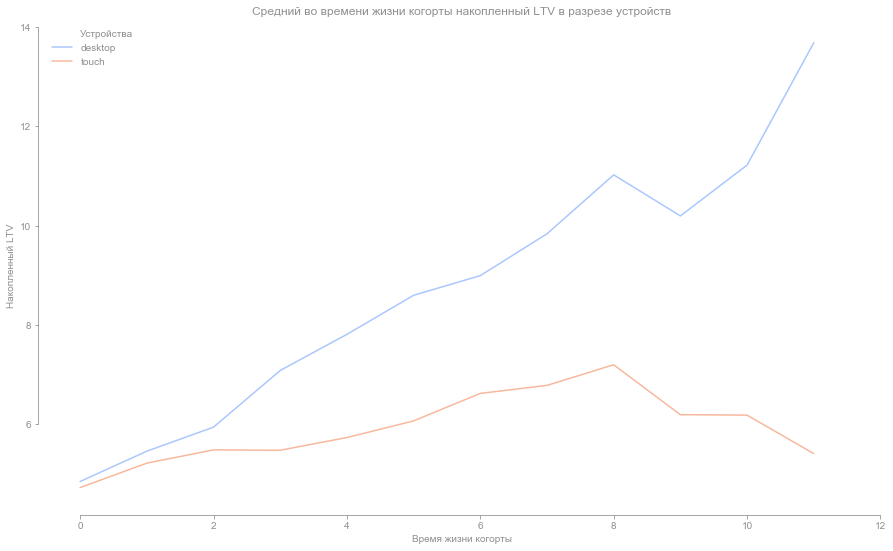

In [44]:
# построим месячные когорты с суммой выручки и числом уникальных пользователей в разрезе устройств
ltv_device_cohorts = cohort_builder(data=orders, 
                                    ts_column='buy_ts', 
                                    grouper='device', 
                                    period='month', 
                                    agg={'revenue': 'sum', 'uid': 'nunique'})

ltv_device_cohorts['ltv'] = ltv_device_cohorts['revenue'] / ltv_device_cohorts['cohort_size']


# отразим на графике средние накопленные суммы LTV для каждого устройства отдельно
lineplotting(data=cumsum_by_grouper(data=ltv_device_cohorts, grouper='device', values='ltv'), 
             values='ltv', 
             withhue=True, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Накопленный LTV', 
             title='Средний во времени жизни когорты накопленный LTV в разрезе устройств')

plt.legend().texts[0].set_text('Устройства')


# выведем исходные данные для графика
cumsum_by_grouper(data=ltv_device_cohorts, grouper='device', values='ltv').unstack().round(2).fillna('')

На этом графике видно, что пользователи десктопов приносят в среднем больше денег и, что более важно, способны обеспечивать выручку дольше — как минимум на протяжении года. Среди пользователей мобильных устройств меньший по размеру LTV необратимо падает уже после восьмого месяца жизни когорты. Динамика роста LTV на десктопах приближена к общей динамике.

ltv                                       
source_id           1      2     3      4      5     9     10
cohort_lifetime                                              
0                 6.36   6.59  4.59   4.54   4.86  3.95  3.32
1                 7.57   8.19  4.98   4.87   5.22  4.31  3.67
2                 9.11  10.13  5.06   4.95   5.58  4.56  4.34
3                 9.73  12.32  5.24   5.19   7.94  5.09  4.68
4                11.02  14.10  5.50   5.53   8.81  5.31  3.51
5                12.18  15.85  5.73   6.08   9.81  5.82  4.59
6                13.91  13.12  5.97   6.91  10.92  6.28     4
7                15.87  14.37  6.23   7.08  12.39   6.9  3.83
8                19.17  17.85  6.44   7.68  14.29  7.41  4.52
9                22.78  11.97  6.50   7.93  10.34  6.71  6.04
10               25.17  14.80  6.71   9.40  10.52  7.25      
11               30.12  17.75  5.75  12.62  15.17

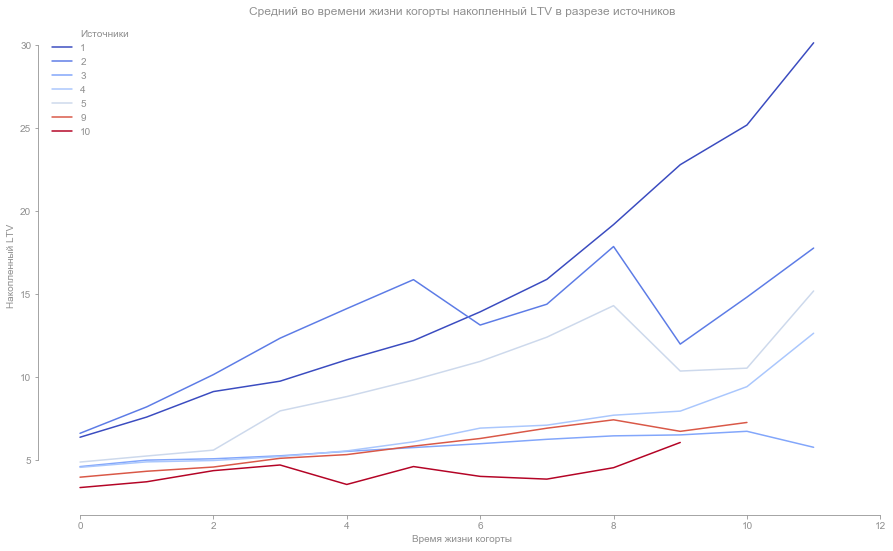

In [45]:
# повторим для источников, дополнительно исключаем источник 7, там всего один заказ
ltv_source_cohorts = cohort_builder(data=orders, 
                                    ts_column='buy_ts', 
                                    grouper='source_id', 
                                    period='month', 
                                    agg={'revenue': 'sum', 'uid': 'nunique'}).query('source_id != 7')

ltv_source_cohorts['ltv'] = ltv_source_cohorts['revenue'] / ltv_source_cohorts['cohort_size']


lineplotting(data=cumsum_by_grouper(data=ltv_source_cohorts, grouper='source_id', values='ltv'), 
             values='ltv', 
             withhue=True, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Накопленный LTV', 
             title='Средний во времени жизни когорты накопленный LTV в разрезе источников')

plt.legend().texts[0].set_text('Источники')


cumsum_by_grouper(data=ltv_source_cohorts, grouper='source_id', values='ltv').unstack().round(2).fillna('')

В разрезе источников динамика несколько различается для каждого. Так, источник 9 совсем перестает приносить деньги к одиннадцатому месяцу жизни когорты, а источник 10 — уже к десятому. Наиболее прибыльный — источник 1, он же обеспечивает самый стабильный рост, а наименее — источник 10. Второй по прибыльности источник 2 до пятого месяца обгоняет источник 1, но по после дважды проседает.

<a id='2025'></a>
#### Выводы из анализа метрик продаж


1. **Время до первой покупки**:
    - В основном пользователи совершают «быстрые покупки», большинство укладываются в 1 час 15 минут, а минимальное время до первой покупки — 8 минут.
    - По устройствам: на десктопе обычно первая покупка совершается спустя 1 час и 6 минут после начала первой сессии, а на мобильном устройстве — через 2 часа и 16 минут, т.е. пользователям десктопа нужно меньше времени.
    - По источникам: быстрее всего доходят до покупки пользователи из источника 10 (21 минута), а медленнее всего — из источника 9.


2. **Количество заказов за период**:
    - В среднем делают 119 заказов в день, 819 в неделю, 3 339 в месяц.
    - Динамика количества заказов в целом совпадает с динамикой активности: больше заказов с октября по март, меньше — в летние месяцы. Кроме того, много заказов было сделано в мае. Аналогично активности есть отдельные дни с заметно большим количеством заказов, чем среднее по месяцу.
    - При оценке количества повторных заказов по когортам было видно, что большинство совершаются в нулевой месяц жизни когорты, а объем повторных заказов низок — в этом смысле результаты пересекаются с когортным анализом возвращаемости.
    - Среди устройств лидирует десктоп (35 920 заказов), на полной версии сайта делается заказов более чем в 4 раза больше, чем на мобильной (8 604 заказа).    
    - Меньше всего заказов сделали с источников 9 и 10 (в сумме 3 046 заказов), а больше всего — с 3 и 4 (в сумме 24 000 заказов). Разница между наименьшим и наибольшим по параметру источниками — более чем в 8 раз.


3. **Средний чек**:
    - Средняя выручка в день — 660 денег, в неделю — 4 533, в месяц — 18 482.
    - В динамике выручки по периодам в сравнении с динамикой активности и количества заказов есть и пересечения, и новые данные. По месяцам выручка меньше всего летом (особенно в июне), растет в октябре-декабре и марте. В январе выручка уменьшается, а, например, количество заказов — нет. Можем предположить, что в несовпадающие периоды были совершены более дорогие или более дешевые заказы относительно общих тенденций. В остальные месяцы рост количества заказов и/или выручки приходится на отдельные дни, а значит там имеют значение отдельные события.
    - В разложении по когортам в большинстве случаев лучшая выручка приходится на нулевой месяц жизни, т.к. повторных заказов относительно немного. Исключение — в когорте 2017-09 была высокая выручка на 3-й месяц жизни (это декабрь). Самые успешные по выручке — когорты октября-декабря, где сумма за нулевой месяц жизни превысила среднюю месячную выручку.


4. **Прибыльность (LTV)**:
    - По накопленному LTV среди когорт лучше всего показали себя 2017-06 и 2017-09, но сентябрьская когорта росла гораздо быстрее.
    - По усредненному накопленному LTV мы оценили типичную динамику по месяцам жизни когорт в целом, для устройств и источников. Обычно накопленный LTV стабильно растет до 9-го месяца, на нем немного проседает и на 10-м и 11-м месяцах продолжает рост. 
    - В разрезе по устройствам пользователи десктопов приносят больше прибыли и дольше обеспечивают выручку, на протяжении всего года жизни когорты; пользователи мобильных устройств LTV меньше и падает с 8-го месяца.
    - В разрезе по источникам наиболее прибыльные — 1 и 2, наименее прибыльные — 9 и 10. Динамика по времени жизни когорт для каждого источника различается.

<a id='203'></a>
### Маркетинговые метрики

В этой группе мы рассмотрим общее количество затрат на маркетинг по каждому месяцу и источнику, посчитаем стоимость привлечения одного покупателя и сопоставим с прибылью, чтобы узнать степень окупаемости наших затрат, все это также по времени и источникам.

<a id='2031'></a>
#### Сколько всего денег потратили?

Суммируем все затраты на маркетинг и распределим их по месяцам и источникам.

In [46]:
print('Всего потрачено на маркетинг: {:.2f}'.format(costs['costs'].sum()))

Всего потрачено на маркетинг: 329131.62


source_id,1,2,3,4,5,9,10,month_sum
dt,,,,,,,,
2017-06,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22,18015.00
2017-07,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82,18240.59
2017-08,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57,14790.54
2017-09,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67,24368.91
2017-10,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24,36322.88
2017-11,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36,37907.88
2017-12,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86,38315.35
2018-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35,33518.52
2018-02,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88,32723.03


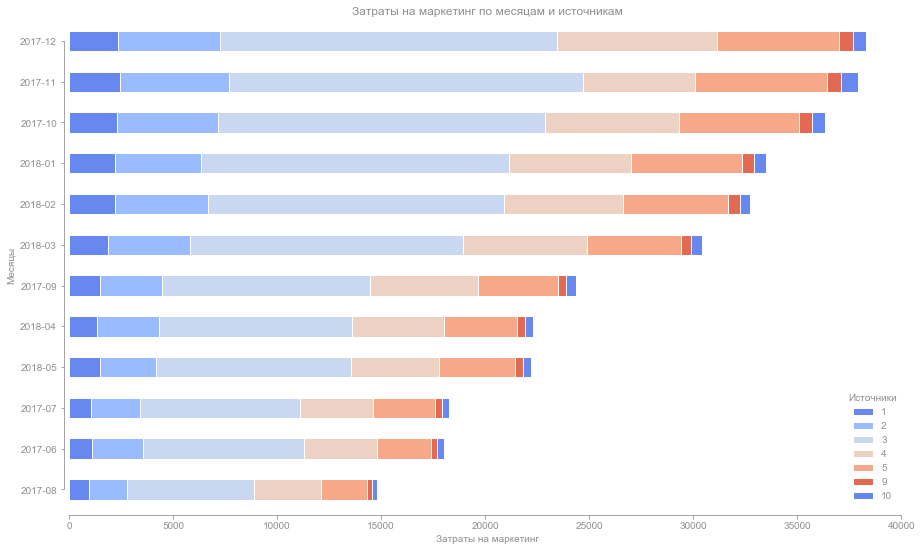

In [47]:
# распределим в сводной таблице затраты по месяцам и источникам, отсортируем по общей сумме за месяц
costs_month_source = costs.pivot_table(index=costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m'), 
                                       columns='source_id', 
                                       values='costs', 
                                       aggfunc='sum')

costs_month_source['month_sum'] = costs_month_source.sum(axis=1) # посчитаем общую сумму затрат для сортировки

# строим диаграмму
(costs_month_source
 .sort_values(by='month_sum')
 .drop('month_sum', axis=1) # удаляем ненужный столбец с суммой
 .plot.barh(stacked=True)
 .set(xlabel='Затраты на маркетинг', ylabel='Месяцы', title='Затраты на маркетинг по месяцам и источникам'))

plt.legend(title='Источники') # заголовок легенды
sns.despine(trim=True, offset=5) # выключение ненужных осей

# выведем исходные данные
costs_month_source.append(costs_month_source.sum().rename('source_sum'))

Динамика затрат, в общем-то, совпадает с активностью пользователей. На этой диаграмме визуально выделяются две группы — наибольшие по затратам и, как мы помним, самые активные октябрь-декабрь 2017 (причем больше всего в декабре), а далее — январь-март 2018, где также активность была высока, но меньше. Меньше всего потратили на летние месяцы, где активность в основном падает. 

По источникам во все месяцы лидирует по затратам источник 3, а меньше всего тратят также во все месяцы на источники 9 и 10.

<a id='2032'></a>
#### Сколько стоило привлечение одного покупателя из каждого источника?

Для оценки стоимости привлечения посчитаем метрику CAC — сумму денег, в которую обходится новый клиент — как отношение затрат за месяц и размера когорты за этот же месяц. Для этого используем существующие расчеты LTV и сопоставим средние накопленные суммы обоих показателей, а также посмотрим на CAC по источикам.

In [48]:
# соединим данные когортного анализа выручки с данными о затратах по месяцам
costs_cohorts = ltv_cohorts.join(costs
                                 .groupby(costs['dt'].astype('datetime64[M]'))
                                 .agg({'costs': 'sum'}), 
                                 on='first_month')

# рассчитаем стоимость привлечения одного покупателя как отношение затрат к размеру когорты
costs_cohorts['cac'] = costs_cohorts['costs'] / costs_cohorts['cohort_size']

# распределим показатель CAC по месяцам и времени жизни когорты
cac_pivot = costs_cohorts.pivot(index='first_month', columns='cohort_lifetime', values='cac')

,ltv,cac
cohort_lifetime,,
0,4.81,9.76
1,5.42,9.93
2,5.86,9.88
3,6.78,9.96
4,7.42,10.01
5,8.13,9.93
6,8.57,10.05
7,9.30,10.12
8,10.35,10.41


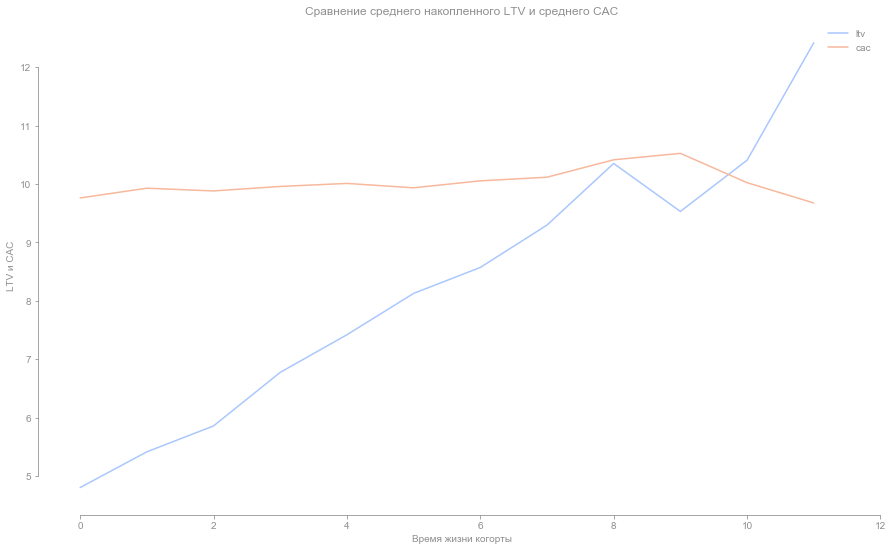

In [49]:
# соединим средний накопленный LTV и средний CAC по времени жизни когорт
ltv_cac_cumsum = pd.merge(ltv_pivot.mean().rename('ltv'), 
                          costs_cohorts.groupby('cohort_lifetime')['cac'].mean(), 
                          left_index=True, 
                          right_index=True)


# сравним показатели на графике
(sns.lineplot(data=ltv_cac_cumsum, 
              palette='coolwarm', 
              dashes=False)
 .set(xlim=(None, 12), 
      xlabel='Время жизни когорты', 
      ylabel='LTV и CAC', 
      title='Сравнение среднего накопленного LTV и среднего CAC'))

sns.despine(trim=True, offset=5)


# выведем исходные данные
ltv_cac_cumsum.round(2)

Мы видим, что в среднем к 10-му месяцу жизни когорты LTV превышает CAC — значит, к этому времени мы можем ожидать окупаемость.

source_id,1,2,3,4,5,9,10
cohort_lifetime,,,,,,,
0,7.71,13.27,14.73,6.84,8.06,5.69,5.19
1,7.83,13.86,14.97,6.95,8.06,5.63,5.5
2,7.80,13.81,14.90,6.97,7.98,5.21,5.64
3,7.87,13.95,14.95,7.10,7.81,5.3,5.56
4,7.80,13.71,15.08,7.30,7.75,5.3,5.21
5,7.52,13.51,15.00,7.49,7.58,5.08,7.28
6,7.54,13.53,15.31,7.75,7.51,5.01,5.01
7,7.46,13.55,15.44,8.34,7.09,5.02,5.24
8,7.50,12.67,15.63,8.99,7.24,5.04,5.28


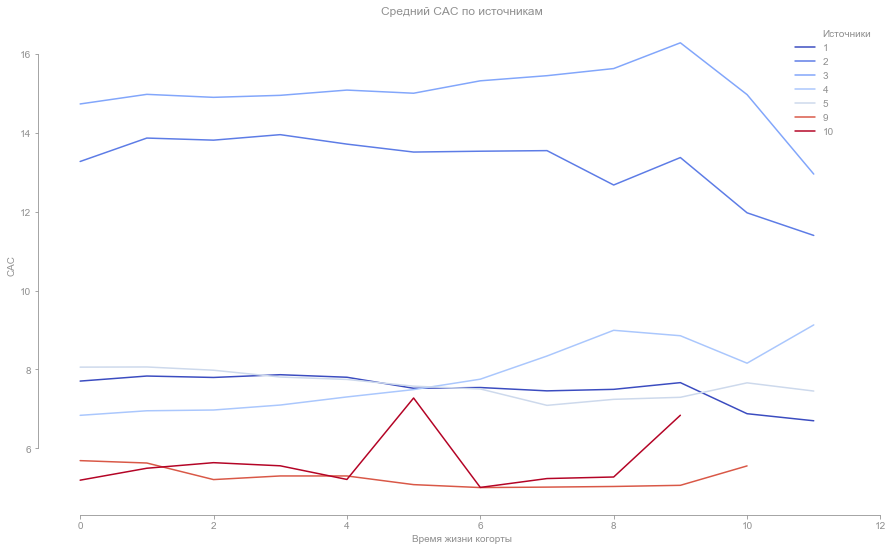

In [50]:
# повторим расчет CAC, но с использованием данных о прибыли, сгруппированных по месяцу и источнику
costs_source_cohorts = ltv_source_cohorts.join(costs
                                               .groupby([costs['dt'].astype('datetime64[M]'), 'source_id'])
                                               .agg({'costs': 'sum'}), 
                                               on=['first_month', 'source_id'])

costs_source_cohorts['cac'] = costs_source_cohorts['costs'] / costs_source_cohorts['cohort_size']


# строим линейный график на основе средних накопленных сумм CAC
lineplotting(data=costs_source_cohorts.groupby(['cohort_lifetime', 'source_id'])['cac'].mean(), 
             values='cac', 
             withhue=True, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='CAC', 
             title='Средний CAC по источникам')

plt.legend().texts[0].set_text('Источники')


# выведем исходные данные
costs_source_cohorts.groupby(['cohort_lifetime', 'source_id'])['cac'].mean().unstack().round(2).fillna('')

Динамика CAC по источникам для каждого немного различается — для каких-то стоимость со временем растет, а для каких-то падает. Также, как и при расчете LTV по источникам, мы не обладаем данными о последнем месяце источника 9 и двух последних месяцев источника 10; вне зависимости от этого, это два наименее затратных источника (мы это также видели на столбцовой диаграмме). А наиболее дорого обошлись клиенты из источников 2 и 3.

<a id='2033'></a>
#### Насколько окупились расходы?

Посчитаем показатель ROMI — возврат маркетинговых инвестиций — по упрощенной формуле: разделив LTV на CAC. Расходы можно считать окупившимися, если они превысят 100%. Рассмотрим окупаемость всех затрат и в разрезе по источникам.

cohort_lifetime
0      50.71%
1      54.73%
2      59.47%
3      68.24%
4      74.47%
5      81.97%
6      85.45%
7      92.24%
8     100.63%
9      91.80%
10    104.56%
11    128.33%
Name: romi, dtype: object

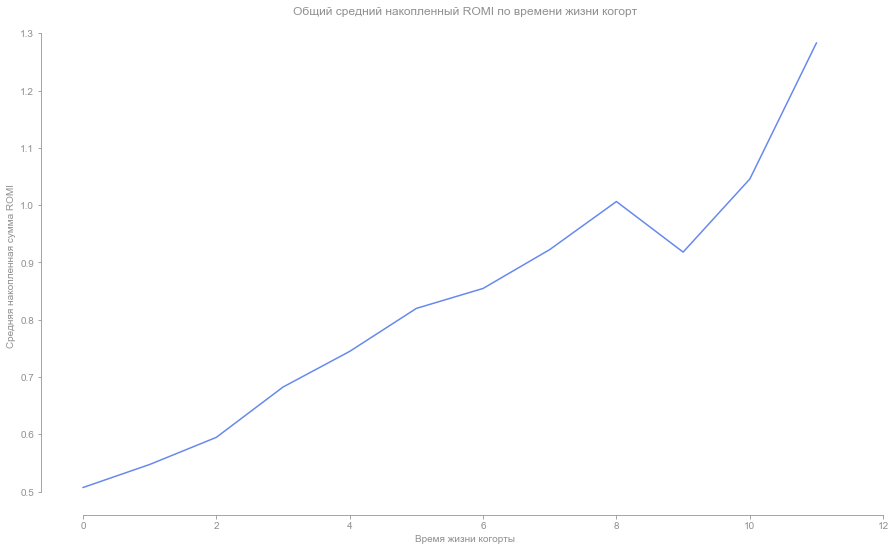

In [51]:
# возьмем данные о затратах по месячным когортам и вычислим ROMI как отношение LTV к CAC
costs_cohorts['romi'] = costs_cohorts['ltv'] / costs_cohorts['cac']

# распределим ROMI по месяцам и времени жизни когорт
romi_pivot = costs_cohorts.pivot_table(index='first_month', 
                                       columns='cohort_lifetime', 
                                       values='romi', 
                                       aggfunc='mean')


# отобразим средние накопленные суммы ROMI в течение жизни когорты
lineplotting(data=romi_pivot.cumsum(axis=1).mean(axis=0), 
             values=romi_pivot.cumsum(axis=1).mean(axis=0).values, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Средняя накопленная сумма ROMI', 
             title='Общий средний накопленный ROMI по времени жизни когорт')


# выведем исходные данные
romi_pivot.cumsum(axis=1).mean(axis=0).rename('romi').map('{:.2%}'.format)

Интересно, что ROMI почти повторяет динамику LTV — также проседает к девятому месяцу и после возвращается к росту. Хотя показатель достигает момента окупаемости в 100% как раз на восьмом месяце, но так как здесь превышается этот уровень всего на 0,63% и сразу же после мы наблюдаем падение, то надежнее будет сказать — инвестиции в среднем окупаются к десятому месяцу жизни когорты.

romi                                                    
source_id             1        2       3        4        5        9       10
cohort_lifetime                                                             
0                 83.97%   52.94%  31.26%   70.99%   61.78%   73.22%  68.39%
1                 99.11%   59.64%  33.35%   73.65%   66.69%   80.58%  70.35%
2                120.52%   74.15%  34.09%   74.94%   72.08%   90.49%  80.41%
3                127.88%   90.16%  35.20%   77.24%  106.51%   99.36%  82.99%
4                146.39%  104.33%  36.76%   79.92%  119.15%  103.70%  69.44%
5                165.10%  118.34%  38.52%   85.58%  134.83%  116.10%  63.87%
6                188.85%   98.04%  39.38%   93.73%  151.33%  126.82%  81.55%
7                216.71%  107.78%  40.87%   85.91%  175.23%  139.57%  74.33%
8                260.79%  138.46%  41.89%   86.23%  199.97%  149.56%  81.17%
9                307.09%   94.68%  40.51%   90.49%  143.61%  135.71%  88.30%
10               367.28%  124.92%  44.78%  112.27%  138.98%  133.95%        
11               449.60%  155.79%  44.39%  138.26%  203.52%

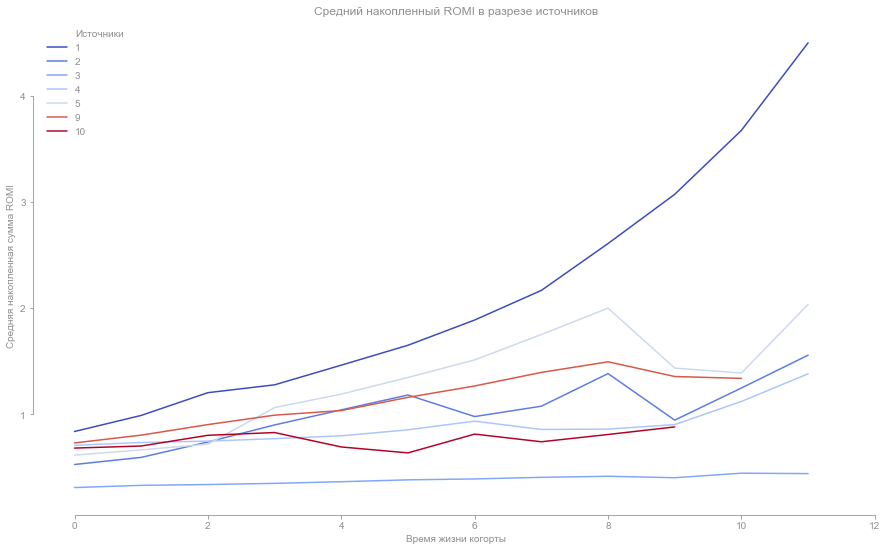

In [52]:
# повторим расчет ROMI на основе затрат по месячным когортам и источникам 
costs_source_cohorts['romi'] = costs_source_cohorts['ltv'] / costs_source_cohorts['cac']


lineplotting(data=cumsum_by_grouper(data=costs_source_cohorts, grouper='source_id', values='romi'), 
             values='romi', 
             withhue=True, 
             rawdata=False, 
             xlim=(None, 12), 
             xlabel='Время жизни когорты', 
             ylabel='Средняя накопленная сумма ROMI', 
             title='Средний накопленный ROMI в разрезе источников')

plt.legend().texts[0].set_text('Источники')


(cumsum_by_grouper(data=costs_source_cohorts, grouper='source_id', values='romi').unstack()
 .applymap('{:.2%}'.format).replace('nan%', ''))

Если рассмотреть отдельно затраты на каждый источник, то окупили свои затраты все, кроме источников 3 и 10. В большинстве случаев затраты окупаются не позже четвертого месяца жизни (кроме источника 4, он оказался более долгим). Наиболее эффективным можно признать источник 1 — если вкладываться только в него, то затраты окупаются уже на втором месяце жизни когорты, а к концу периода можно вернуть до 350% инвестиций. 

<a id='2034'></a>
#### Выводы из анализа маркетинговых метрик


1. **Общие затраты на маркетинг**:
    - За весь наблюдаемый период, за год потратили на привлечение почти 330 000 денег.
    - В распределении по месяцам затраты совпадают с динамикой пользовательской активности — наибольшие затраты были сделаны в самые активные октябрь-декабрь (112,5 тысяч денег в сумме, больше всего в декабре — 38,5 тысяч). Меньше всего потратили в летние месяцы. Здесь остается открытым вопрос, что было первично — тенденции пользовательской активности, если они примерно повторяются год от года, заставляют сервис больше вкладываться в привлечение для борьбы с конкурентами или пользовательская активность на сервисе следует за маркетинговой активностью.
    - Среди источников больше всего тратят на 3, а меньше всего — на 9 и 10.


2. **Стоимость привлечения одного покупателя (CAC)**:
    - Средний CAC почти не меняется в течение всего жизни когорт, варьируется в диапазоне от 9,63 до 10,41. Обычно LTV превышает CAC на 10-м месяце.
    - Меньше всего стоило привлечение одного клиента из источников 9 и 10, а больше всего — из источников 2 и 3.


3. **Окупаемость расходов (ROMI)**:
    - В среднем инвестиции окупаются к 10-му месяцу жизни когорты.
    - В разрезе по источникам мы видим разную картину: если тратить на каждый источник отдельно, то большая часть окупится не позже 4-го месяца. При этом источники 3 и 10 не окупились за наблюдаемый период, а источник 4 окупился только к 10-му месяцу. Наиболее эффективным оказался источник 1, который окупился на втором месяце жизни когорты и к концу периода вернул почти 350% инвестиций.

<a id='part_3'></a>
## Шаг 3. Общий вывод: куда и сколько стоит вкладывать денег?

Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

Мы рассмотрели метрики продуктовой активности пользователей, метрики продаж и затраты на маркетинг — в целом, во временной динамике, по устройствам и источникам. Это позволит скорректировать маркетинговые затраты за счет выбора более эффективных платформ и источников.

Важно отметить, что в анализе участвовали не все источники. Ниже представлен список всех источников, по которым были доступны данные, но их не хватило для анализа 6 и 7 источника, активности и заказов по ним было крайне мало.

In [53]:
print('ID источников: ', end='')
print(*(np.sort(visits['source_id'].unique())), sep=', ')

ID источников: 1, 2, 3, 4, 5, 6, 7, 9, 10


В остальном, можно сделать следующие выводы:


1. Динамика затрат по месяцам сейчас совпадает с аналогичной динамикой пользовательской активности, количества заказов и среднего чека. Снова повторим, что можно только предполагать о причине и следствии в данном случае — а вероятно, влияют оба фактора: большая маркетинговая активность наращивает число пользователей и заказы в то время, как происходит количественно больше культурных событий и они более масштабные. В таком случае здесь можно только сказать, что распределение затрат по времени сделано корректно.


2. В нашей оценке было важно сравнить CAC и LTV и обратить внимание на ROMI как результирующую это сравнение — именно указанные метрики больше всего говорят о состоянии бизнеса, полагающегося на юниты. По нашим расчетам, в среднем прибыль от клиента превышает затраты на его привлечение за 10 месяцев, следовательно и окупаемость начинается с 10-го месяца жизни когорты, что довольно долго.


3. Среди платформ преобладала десктопная версия сайта, она обгоняет мобильную по количеству пользователей и сессий, типичной длине сессии, показателю возвращаемости; на десктопах обычно быстрее переходят к первой покупке, сделано больше заказов и принесено больше выручки, а LTV растет дольше и сильнее в сравнении с мобильной версией сайта. Возможно, стоит отдельно проанализировать с точки зрения продукта причины такого различия, особенно в LTV — мобильная версия может стать точкой роста.


4. Есть смысл скорректировать затраты по источникам. Сейчас больше всего тратится на источник 3, покупатель с него стоит дороже всех. И хотя статистика показывает, что он лидирует по количеству заказов, ценность с них невысокая. Даже половина затрат на этот источник за наблюдаемый период не окупается. Лучше всех по ключевым метрикам показали себя источники 1 и 2 — у них лучшие показатели возвращаемости и прибыльности, однако CAC по источнику 2 довольно высокий, поэтому возврат инвестиций на протяжении жизни когорт оказался нестабилен, он несколько раз проваливался ниже предела окупаемости. У источника 1 таких проблем не обнаружено, он окупился быстрее всех, за 2 месяца, а к концу периода вернул чуть менее 350% вложенных денег. Конечно, такой ROMI обусловлен в том числе и невысокими затратами на привлечение, и в случае роста инвестиций их нужно будет сбалансировать. Кроме того, предлагаем присмотреться к источнику 5 — он второй по ROMI и окупился за 3 месяца. 


5. Также считаем нужным упомянуть, что метрика количества заказов, похоже, не очень хорошо отражает эффективность источников — больше всего их сделали пользователи из источников 3 и 4, а они с точки зрения LTV и ROMI провальны.


Таким образом, есть смысл пересмотреть наиболее крупные инвестиции в источник 3 и обратить внимание на самый эффективный источник 1 и средний, но стабильный источник 5 — у них отличные показатели Retention Rate, LTV и ROMI. Возможности оценки проблем и развития мобильной версии сайта также стоит рассмотреть как потенциальный рост активности, заказов и выручки.